# Color Space

본 파일에서는 Bloch Sphere에 Color Space를 정의하는 방법을 소개합니다.

## Import Packages

In [1]:
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import transpile, assemble, Aer
from qiskit.visualization import plot_histogram

## Color Space Definiton

기존 color space는 Cartesian Coordinates에서 x,y,z 값에 각각 R,G,B 값을 할당하는 형태로 정육면체를 이루고 있었다.

그러나 Quantum Image Processing 에서는 Bloch Sphere의 표면 위에 R,G,B 값을 할당해야 하므로 규격화를 한 다음 매핑한다.

In [24]:
class RGBMapping3D_cart:
    def __init__(self, color_index, color_list):
        self.color_index = np.array(color_index)
        self.color_list = np.array(color_list)

    def plot_points(self):
        fig = plt.figure(figsize=(14,10))
        ax = fig.add_subplot(111, projection='3d')

        # RGB 값에 해당하는 좌표를 점으로 플로팅
        points = np.array([point[0] for point in self.color_list])
        colors = self.color_index / 255

        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, marker='o')
        ax.view_init(30,60)
        ax.set_xlabel('Red')
        ax.set_ylabel('Green')
        ax.set_zlabel('Blue')

        plt.show()

In [26]:
classic_color_list = []
classic_color_index = []
for i in tqdm(range(0,256)):
    for j in range(0,256):
        for k in range(0,256):
            classic_color_index.append([i,j,k])
            P = np.array([i,j,k])
            classic_color_list.append([P])

  0%|          | 0/256 [00:00<?, ?it/s]

100%|██████████| 256/256 [05:56<00:00,  1.39s/it]  



Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)



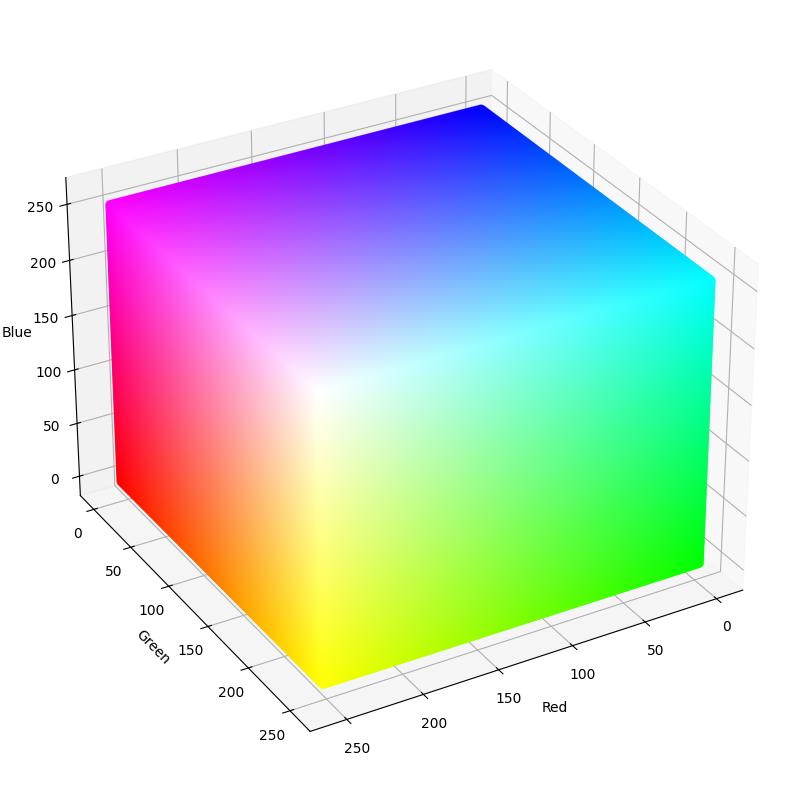

In [27]:
rgb_mapping_3d_classic = RGBMapping3D_cart(classic_color_index[:], classic_color_list[:])

# 좌표를 플로팅
rgb_mapping_3d_classic.plot_points()

# A novel RGB color space

### RGB 값을 Bloch Sphere에 매핑하는 식 구현하고, 전처리를 통해 중복값을 제거한 다음, Quantum Circuit으로 컬러 스페이스 표현

In [1]:
import math
import numpy as np

# 색상 리스트, 색상 인덱스, 색상 각도 리스트 초기화
color_index = []
color_coord = []
color_angle = []

coordinates_set = set()  # 중복을 추적하기 위한 set

def calculate_coordinates():
    global color_coord, color_index, color_angle

    def add_to_list(n, m, k, x, y, z, theta, phi):
        # 좌표를 소수점 6자리까지 반올림하여 정밀도 설정
        #rounded_coord = (x,y,z)
        #if rounded_coord not in coordinates_set:  # 중복되지 않은 좌표만 추가
        #coordinates_set.add(rounded_coord)
        P = np.array([x, y, z])
        color_index.append([n, m, k])
        color_coord.append(P)
        color_angle.append([theta, phi])

    # Northern hemisphere
    for a in range(0,255):
        for i in range(0, int(np.floor((255-a)/2))+1):
            m = 255-a-i
            n = i
            for k in range(i,m+1):
                theta = (255-a)*np.pi/510+np.pi/1020-(np.pi/510) * (i+1)/(np.floor((255-a)/2)+1)
                phi = (k - i) * np.pi / (3 * (m - i)) if m != i else 0
                x = np.sin(theta) * np.cos(phi)
                y = np.sin(theta) * np.sin(phi)
                z = np.cos(theta)
                add_to_list(m, k, n, x, y, z, theta, phi)
            for k in range(i,m+1):
                theta = (255-a)*np.pi/510+np.pi/1020-(np.pi/510) * (i+1)/(np.floor((255-a)/2)+1)
                phi = (k - i) * np.pi / (3 * (m - i)) if m != i else 0
                x = np.sin(theta) * np.cos(phi + 2*np.pi/3)
                y = np.sin(theta) * np.sin(phi + 2*np.pi/3)
                z = np.cos(theta)
                add_to_list(n, m, k, x, y, z, theta, phi + 2*np.pi/3)
            for k in range(i,m+1):
                theta = (255-a)*np.pi/510+np.pi/1020-(np.pi/510) * (i+1)/(np.floor((255-a)/2)+1)
                phi = (k - i) * np.pi / (3 * (m - i)) if m != i else 0
                x = np.sin(theta) * np.cos(phi + 4*np.pi/3)
                y = np.sin(theta) * np.sin(phi + 4*np.pi/3)
                z = np.cos(theta)
                add_to_list(k, n, m, x, y, z, theta, phi + 4*np.pi/3)

            for k in range(1,m-i+1):
                theta = (255-a)*np.pi/510+np.pi/1020-(np.pi/510) * (i+1)/(np.floor((255-a)/2)+1)
                phi = k * np.pi / (3 * (m - i)) if m != i else 0
                x = np.sin(theta) * np.cos(phi + np.pi/3)
                y = np.sin(theta) * np.sin(phi + np.pi/3)
                z = np.cos(theta)
                add_to_list(m-k, m, n, x, y, z, theta, phi + math.pi/3)
            for k in range(1,m-i+1):
                theta = (255-a)*np.pi/510+np.pi/1020-(np.pi/510) * (i+1)/(np.floor((255-a)/2)+1)
                phi = k* np.pi / (3 * (m - i)) if m != i else 0
                x = np.sin(theta) * np.cos(phi + 3*np.pi/3)
                y = np.sin(theta) * np.sin(phi + 3*np.pi/3)
                z = np.cos(theta)
                add_to_list(n, m - k, m, x, y, z, theta, phi + 3*np.pi/3)
            for k in range(1,m-i+1):
                theta = (255-a)*np.pi/510+np.pi/1020-(np.pi/510) * (i+1)/(np.floor((255-a)/2)+1)
                phi = k* np.pi / (3 * (m - i)) if m != i else 0
                x = np.sin(theta) * np.cos(phi + 5*np.pi/3)
                y = np.sin(theta) * np.sin(phi + 5*np.pi/3)
                z = np.cos(theta)
                add_to_list(m, n, m-k, x, y, z, theta, phi + 5*np.pi/3)

    # Southern hemisphere
    for a in range(1,255):
        for i in range(0, int(np.floor((255-a)/2))+1):
            m = 255-i
            n = i+a
            for k in range(i,m+1):
                theta = (255+a)*np.pi/510-np.pi/1020+(np.pi/510) * (i+1)/(np.floor((255-a)/2)+1)
                phi = (k - n) * np.pi / (3 * (m - n)) if m != n else 0
                x = np.sin(theta) * np.cos(phi)
                y = np.sin(theta) * np.sin(phi)
                z = np.cos(theta)
                add_to_list(m, k, n, x, y, z, theta, phi)
            for k in range(i,m+1):
                theta = (255+a)*np.pi/510-np.pi/1020+(np.pi/510) * (i+1)/(np.floor((255-a)/2)+1)
                phi = (k - n) * np.pi / (3 * (m - n)) if m != n else 0
                x = np.sin(theta) * np.cos(phi + 2*np.pi/3)
                y = np.sin(theta) * np.sin(phi + 2*np.pi/3)
                z = np.cos(theta)
                add_to_list(n, m, k, x, y, z, theta, phi + 2*np.pi/3)
            for k in range(i,m+1):
                theta = (255+a)*np.pi/510-np.pi/1020+(np.pi/510) * (i+1)/(np.floor((255-a)/2)+1)
                phi = (k - n) * np.pi / (3 * (m - n)) if m != n else 0
                x = np.sin(theta) * np.cos(phi + 4*np.pi/3)
                y = np.sin(theta) * np.sin(phi + 4*np.pi/3)
                z = np.cos(theta)
                add_to_list(k, n, m, x, y, z, theta, phi + 4*np.pi/3)


            for k in range(1,m-i+1):
                theta = (255+a)*np.pi/510-np.pi/1020+(np.pi/510) * (i+1)/(np.floor((255-a)/2)+1)
                phi = k * np.pi / (3 * (m - n)) if m != n else 0
                x = np.sin(theta) * np.cos(phi + np.pi/3)
                y = np.sin(theta) * np.sin(phi + np.pi/3)
                z = np.cos(theta)
                add_to_list(m-k, m, n, x, y, z, theta, phi + math.pi/3)
            for k in range(1,m-i+1):
                theta = (255+a)*np.pi/510-np.pi/1020+(np.pi/510) * (i+1)/(np.floor((255-a)/2)+1)
                phi = k * np.pi / (3 * (m - n)) if m != n else 0
                x = np.sin(theta) * np.cos(phi + 3*np.pi/3)
                y = np.sin(theta) * np.sin(phi + 3*np.pi/3)
                z = np.cos(theta)
                add_to_list(n, m - k, m, x, y, z, theta, phi + 3*np.pi/3)
            for k in range(1,m-i+1):
                theta = (255+a)*np.pi/510-np.pi/1020+(np.pi/510) * (i+1)/(np.floor((255-a)/2)+1)
                phi = k * np.pi / (3 * (m - n)) if m != n else 0
                x = np.sin(theta) * np.cos(phi + 5*np.pi/3)
                y = np.sin(theta) * np.sin(phi + 5*np.pi/3)
                z = np.cos(theta)
                add_to_list(m, n, m-k, x, y, z, theta, phi + 5*np.pi/3)
                    
    # equator
    for a in range(1):
        for i in range(0, int(np.floor((255-a)/2))):
            m = 255-i
            n = i
            for k in range(i,m+1):
                theta = np.pi/2+((-1)**i)*np.pi/1020*i/127
                phi = (k - i) * np.pi / (3 * (m - i)) if m != i else 0
                x = np.sin(theta) * np.cos(phi)
                y = np.sin(theta) * np.sin(phi)
                z = np.cos(theta)
                add_to_list(m, k, n, x, y, z, theta, phi)
            for k in range(i,m+1):
                theta = np.pi/2+((-1)**i)*np.pi/1020*i/127
                phi = (k - i) * np.pi / (3 * (m - i)) if m != i else 0
                x = np.sin(theta) * np.cos(phi + 2*np.pi/3)
                y = np.sin(theta) * np.sin(phi + 2*np.pi/3)
                z = np.cos(theta)
                add_to_list(n, m, k, x, y, z, theta, phi + 2*np.pi/3)
            for k in range(i,m+1):
                theta = np.pi/2+((-1)**i)*np.pi/1020*i/127
                phi = (k - i) * np.pi / (3 * (m - i)) if m != i else 0
                x = np.sin(theta) * np.cos(phi + 4*np.pi/3)
                y = np.sin(theta) * np.sin(phi + 4*np.pi/3)
                z = np.cos(theta)
                add_to_list(k, n, m, x, y, z, theta, phi + 4*np.pi/3)


            for k in range(1,m-i+1):
                theta = np.pi/2+((-1)**i)*np.pi/1020*i/127
                phi = k * np.pi / (3 * (m - i)) if m != i else 0
                x = np.sin(theta) * np.cos(phi + np.pi/3)
                y = np.sin(theta) * np.sin(phi + np.pi/3)
                z = np.cos(theta)
                add_to_list(m-k, m, n, x, y, z, theta, phi + math.pi/3)
            for k in range(1,m-i+1):
                theta = np.pi/2+((-1)**i)*np.pi/1020*i/127
                phi = k * np.pi / (3 * (m - i)) if m != i else 0
                x = np.sin(theta) * np.cos(phi + 3*np.pi/3)
                y = np.sin(theta) * np.sin(phi + 3*np.pi/3)
                z = np.cos(theta)
                add_to_list(n, m - k, m, x, y, z, theta, phi + 3*np.pi/3)
            for k in range(1,m-i+1):
                theta = np.pi/2+((-1)**i)*np.pi/1020*i/127
                phi = k * np.pi / (3 * (m - i)) if m != i else 0
                x = np.sin(theta) * np.cos(phi + 5*np.pi/3)
                y = np.sin(theta) * np.sin(phi + 5*np.pi/3)
                z = np.cos(theta)
                add_to_list(m, n, m-k, x, y, z, theta, phi + 5*np.pi/3)
    add_to_list(0,0,0,0,0,1,0,0)
    add_to_list(255,255,255,0,0,-1,np.pi,0)

In [2]:
calculate_coordinates()

In [66]:
print(f"고유한 좌표 개수: {len(color_index)}")

고유한 좌표 개수: 25410425


In [3]:
# Convert to numpy arrays for unique operation
color_index_np = np.array(color_index)
color_coord_np = np.array([point for point in color_coord])
color_angle_np = np.array([point for point in color_angle])

# Find unique rows
_, unique_indices = np.unique(color_index_np, axis=0, return_index=True)
color_index_unique = color_index_np[unique_indices]
color_coord_unique = color_coord_np[unique_indices]
color_angle_unique = color_angle_np[unique_indices]

unique_color_coord = color_coord_unique.tolist()
unique_color_index = color_index_unique.tolist()
unique_color_angle = color_angle_unique.tolist()

# 모든 가능한 (m, k, i) 값 생성
all_colors = {(m, k, i) for m in range(256) for k in range(256) for i in range(256)}

# color_index에 있는 값을 집합으로 변환
existing_colors = {tuple(color) for color in unique_color_index}

# 누락된 컬러 값을 찾기 위해 차집합 연산
missing_colors = all_colors - existing_colors

# 누락된 컬러 값 출력
print(f"누락된 컬러 값 개수: {len(missing_colors)}")
print("누락된 컬러 값 예시:", list(missing_colors)[:10])  # 예시로 처음 10개만 출력

누락된 컬러 값 개수: 0
누락된 컬러 값 예시: []


In [6]:
import pandas as pd

In [7]:
for i in range(32):
    data = dict()
    data['index'] = [x for x in unique_color_index[524288*i:524288*(i+1)]]
    data['theta']=[x[0] for x in unique_color_angle[524288*i:524288*(i+1)]]
    data['phi']= [x[1] for x in unique_color_angle[524288*i:524288*(i+1)]]
    df= pd.DataFrame(data)
    df.to_excel(f"A novel color_space_angle{i*8}.xlsx", index=True)

In [8]:
for i in range(32):
    data = dict()
    data['index'] = [x for x in unique_color_index[524288*i:524288*(i+1)]]
    data['theta']=[x[0] for x in unique_color_angle[524288*i:524288*(i+1)]]
    data['phi']= [x[1] for x in unique_color_angle[524288*i:524288*(i+1)]]

    data_ = pd.read_excel(f"A novel color_space_angle{i*8}.xlsx")
    df = pd.DataFrame(data_)

    theta_lower= []
    theta_upper = []
    phi_lower= []
    phi_upper=[]

    for j in range(524288):
        target_theta = df.loc[j, 'theta']

        # 1. target_theta보다 작은 값 중에서 가장 큰 theta 값 (바로 이전 값)
        previous_theta = df[df['theta'] < target_theta]['theta'].max()

        # 2. target_theta보다 큰 값 중에서 가장 작은 theta 값 (바로 다음 값)
        next_theta = df[df['theta'] > target_theta]['theta'].min()

        target_phi = df.loc[j, 'phi']

        # 1. target_theta보다 작은 값 중에서 가장 큰 theta 값 (바로 이전 값)
        previous_phi = df[df['phi'] < target_phi]['phi'].max()

        # 2. target_theta보다 큰 값 중에서 가장 작은 theta 값 (바로 다음 값)
        next_phi = df[df['phi'] > target_phi]['phi'].min()

        theta_lower.append(previous_theta)
        theta_upper.append(next_theta)
        phi_lower.append(previous_phi)
        phi_upper.append(next_phi)
    data['theta left'] = theta_lower
    data['theta right'] = theta_upper
    data['phi left'] = phi_lower
    data['phi right'] = phi_upper
    df= pd.DataFrame(data)
    df.to_excel(f"novel color_space_angle{i*8}.xlsx", index=True)

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

class RGBMapping3D:
    def __init__(self, color_index, color_list):
        self.color_index = np.array(color_index)
        self.color_list = np.array(color_list)

    def plot_points(self):
        fig = plt.figure(figsize=(14,10))
        ax = fig.add_subplot(111, projection='3d')

        # RGB values to coordinates
        points = self.color_list
        colors = self.color_index / 255

        scatter = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, marker='o')
        ax.set_xlabel('Red')
        ax.set_ylabel('Green')
        ax.set_zlabel('Blue')
        
        return fig, ax, scatter

    def rotate_plot(self, save_path='rotation.mp4', frames=360, interval=50):
        # Generate plot and return scatter object
        fig, ax, scatter = self.plot_points()

        # Update function for animation
        def update(frame):
            ax.view_init(elev=30, azim=frame)
            return scatter,

        # Create animation
        ani = FuncAnimation(fig, update, frames=np.arange(0, frames, 2), interval=interval, blit=True)

        # Save animation to file
        ani.save(save_path, writer='ffmpeg')

        plt.show()


# Create object
rgb_mapping_3d = RGBMapping3D(color_index_unique, color_coord_unique)

# Plot and save rotating animation
rgb_mapping_3d.rotate_plot('rotation.mp4', frames=360, interval=50)


MovieWriter ffmpeg unavailable; using Pillow instead.


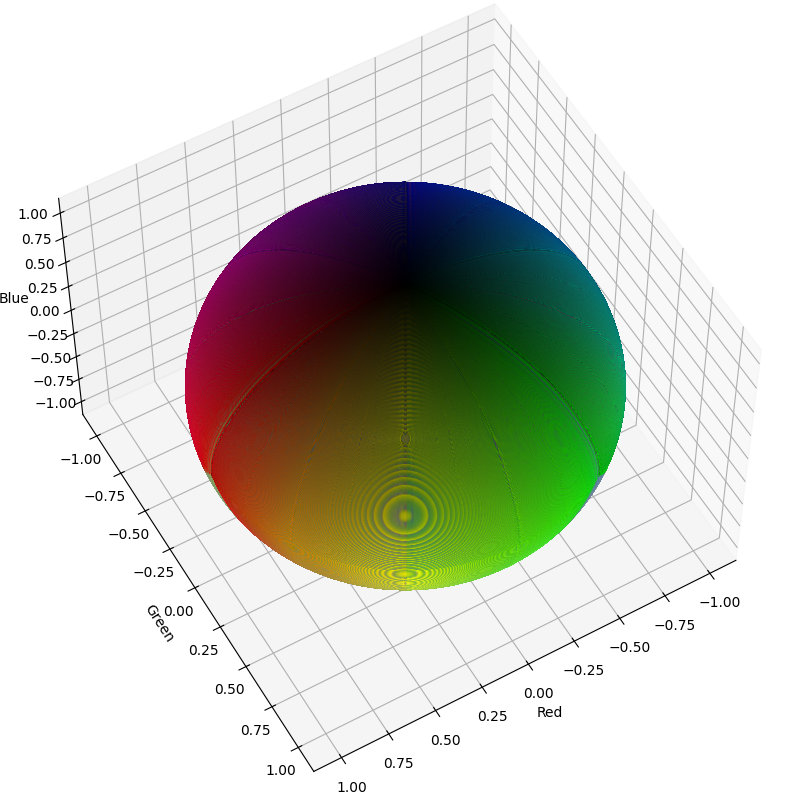

In [49]:
class RGBMapping3D:
    def __init__(self, color_index, color_list):
        self.color_index = np.array(color_index)
        self.color_list = np.array(color_list)

    def plot_points(self):
        fig = plt.figure(figsize=(14,10))
        ax = fig.add_subplot(111, projection='3d')

        # RGB values to coordinates
        points = self.color_list
        colors = self.color_index / 255

        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, marker='o')
        ax.view_init(55, 60)
        ax.set_xlabel('Red')
        ax.set_ylabel('Green')
        ax.set_zlabel('Blue')

        plt.show()

rgb_mapping_3d = RGBMapping3D(color_index_unique, color_coord_unique)

# Plot coordinates
rgb_mapping_3d.plot_points()

In [ ]:
class RGBMapping3DS:
    def __init__(self, color_index, color_list):
        self.color_index = np.array(color_index)
        self.color_list = np.array(color_list)

    def plot_points(self):
        fig = plt.figure(figsize=(14,10))
        ax = fig.add_subplot(111, projection='3d')

        # RGB values to coordinates
        points = self.color_list
        colors = self.color_index / 255

        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, marker='o')
        ax.view_init(270, 60)
        ax.set_xlabel('Red')
        ax.set_ylabel('Green')
        ax.set_zlabel('Blue')

        plt.show()

rgb_mapping_3d_south = RGBMapping3DS(color_index_unique, color_coord_unique)

# Plot coordinates
rgb_mapping_3d_south.plot_points()
print("Thus,", len(color_index_unique))

In [14]:
len(unique_color_angle)

16777216

In [15]:
for i in range(32):
    data = dict()
    data['index'] = [x for x in unique_color_index[524288*i:524288*(i+1)]]
    data['theta']=[x[0] for x in unique_color_angle[524288*i:524288*(i+1)]]
    data['phi']= [x[1] for x in unique_color_angle[524288*i:524288*(i+1)]]
    df= pd.DataFrame(data)
    df.to_excel(f"novelo color_space_angle{i*8}.xlsx", index=True)

In [16]:
data = pd.read_excel("novelo color_space_angle1.xlsx")
df = pd.DataFrame(data)
df

Unnamed: 0          index     theta       phi
0                0      [0, 0, 0]  0.000000  0.000000
1                1      [0, 0, 1]  1.576956  4.188790
2                2      [0, 0, 2]  1.583116  4.188790
3                3      [0, 0, 3]  1.589276  4.188790
4                4      [0, 0, 4]  1.595436  4.188790
...            ...            ...       ...       ...
524283      524283  [7, 255, 251]  1.607781  3.124702
524284      524284  [7, 255, 252]  1.607781  3.128925
524285      524285  [7, 255, 253]  1.607781  3.133148
524286      524286  [7, 255, 254]  1.607781  3.137370
524287      524287  [7, 255, 255]  1.607781  3.141593

[524288 rows x 4 columns]

In [19]:
for i in range(32):
    data = dict()
    data['index'] = [x for x in unique_color_index[524288*i:524288*(i+1)]]
    data['theta']=[x[0] for x in unique_color_angle[524288*i:524288*(i+1)]]
    data['phi']= [x[1] for x in unique_color_angle[524288*i:524288*(i+1)]]

    data_ = pd.read_excel(f"novelo color_space_angle{i+1}.xlsx")
    df = pd.DataFrame(data_)

    theta_left= []
    theta_right = []
    phi_left= []
    phi_right=[]

    for j in range(524288):
        target_theta = df.loc[j, 'theta']

        # 1. target_theta보다 작은 값 중에서 가장 큰 theta 값 (바로 이전 값)
        previous_theta = df[df['theta'] < target_theta]['theta'].max()

        # 2. target_theta보다 큰 값 중에서 가장 작은 theta 값 (바로 다음 값)
        next_theta = df[df['theta'] > target_theta]['theta'].min()

        target_phi = df.loc[j, 'phi']

        # 1. target_theta보다 작은 값 중에서 가장 큰 theta 값 (바로 이전 값)
        previous_phi = df[df['phi'] < target_phi]['phi'].max()

        # 2. target_theta보다 큰 값 중에서 가장 작은 theta 값 (바로 다음 값)
        next_phi = df[df['phi'] > target_phi]['phi'].min()

        theta_left.append(previous_theta)
        theta_right.append(next_theta)
        phi_left.append(previous_phi)
        phi_right.append(next_phi)
    data['theta left'] = theta_left
    data['theta right'] = theta_right
    data['phi left'] = phi_left
    data['phi right'] = phi_right
    df= pd.DataFrame(data)
    df.to_excel(f"A novel color_space_angle{i+1}.xlsx", index=True)

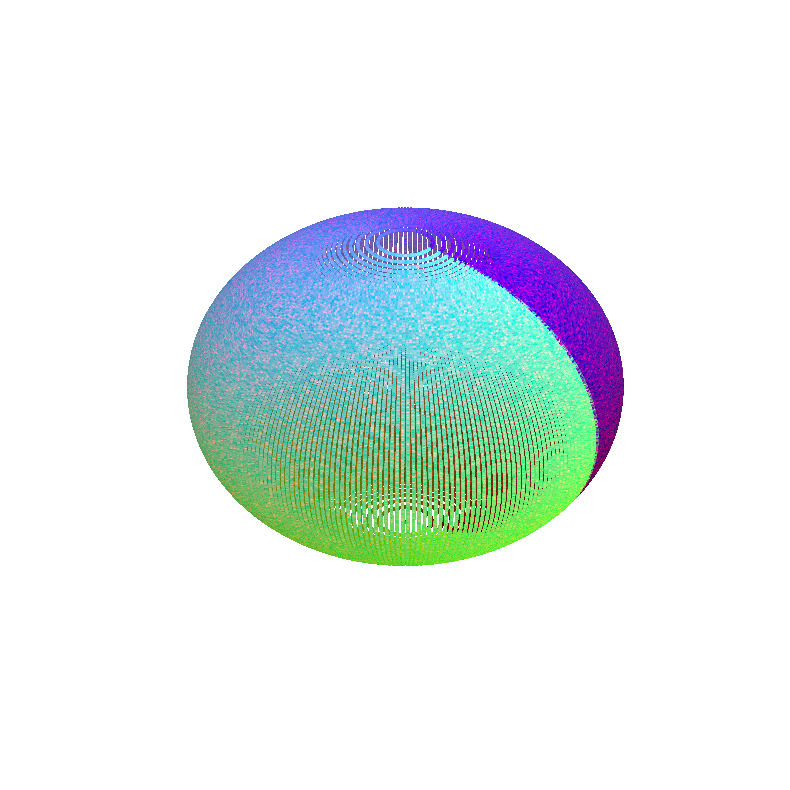

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

def rgb_to_sphere_surface(r, g, b):
    """
    RGB 값을 구의 표면 위에 매핑하기 위해 (x, y, z) 좌표로 변환.
    반지름은 1로 고정되어 구 표면 위에 매핑됨.
    r, g, b 값은 각각 0부터 255 사이의 값이며, 이를 구 표면에 매핑함.
    """
    r_norm = r / 255.0  # 0 ~ 1 사이로 정규화
    g_norm = g / 255.0  # 0 ~ 1 사이로 정규화
    b_norm = b / 255.0  # 0 ~ 1 사이로 정규화

    # RGB 값을 구 좌표계의 각도로 변환
    theta = r_norm * np.pi  # 위도, 0에서 pi까지
    phi = g_norm * 2 * np.pi  # 경도, 0에서 2pi까지
    radius = 1.0  # 반지름을 1로 고정하여 구 표면에 매핑

    # 여기서 b_norm을 활용하여 z 좌표의 분포를 균등하게 반영
    # 각도를 조정하여 구 표면의 다양한 지점에 매핑
    z = 2 * b_norm - 1  # z값을 -1에서 1 사이로 매핑 (구 위에서 위아래로 균일하게 분포)
    xy_proj = np.sqrt(1 - z**2)  # 반지름이 1인 구의 x, y 값의 투영

    x = xy_proj * np.cos(phi)
    y = xy_proj * np.sin(phi)

    return x, y, z

def generate_rgb_samples(n_samples=5000):
    """
    n_samples개의 RGB 값을 랜덤하게 생성하여 구 표면에 균일하게 분포시키는 샘플을 만듬.
    """
    rgb_values = np.random.randint(0, 256, size=(n_samples, 3))
    return rgb_values

# RGB 값을 구의 표면 위에 시각화하는 함수
def plot_rgb_on_sphere(n_samples=5000):
    rgb_values = generate_rgb_samples(n_samples)

    x_vals = []
    y_vals = []
    z_vals = []
    colors = []

    for rgb in rgb_values:
        r, g, b = rgb
        x, y, z = rgb_to_sphere_surface(r, g, b)
        x_vals.append(x)
        y_vals.append(y)
        z_vals.append(z)
        colors.append((r / 255.0, g / 255.0, b / 255.0))

    # 3D 플롯 설정
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # 점을 그릴 때 각 좌표의 색상을 지정
    scatter = ax.scatter(x_vals, y_vals, z_vals, c=colors, s=1)

    # 축을 제거하여 구만 보이도록 설정
    ax.set_axis_off()
    
    return fig, ax, scatter

# 회전 애니메이션 함수
def rotate_plot(n_samples=5000):
    fig, ax, scatter = plot_rgb_on_sphere(n_samples)

    def update(frame):
        ax.view_init(elev=30, azim=frame)
        return scatter,

    ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), interval=50)
    plt.show()

# 회전 애니메이션 실행
rotate_plot(10000000)


In [89]:
data = dict()
data['index'] = [x for x in unique_color_index[:524288*(1)]]
data['theta']=[x[0] for x in unique_color_angle[:524288*(1)]]
data['theta left'] = theta_left
data['theta right'] = theta_right
data['phi']= [x[1] for x in unique_color_angle[:524288*(1)]]
data['phi left'] = phi_left
data['phi right'] = phi_right


df= pd.DataFrame(data)
df.to_excel("novel color_space_angle1.xlsx", index=True)

In [87]:
df.to_excel("novel color_space_angle1.xlsx", index=True)

KeyboardInterrupt: 

In [ ]:
data = pd.read_excel("novel color_space_angle1.xlsx")
df = pd.DataFrame(data)

In [26]:
import pandas as pd
for i in range(32):
    color_space = pd.Series(unique_color_coord[524288*i:524288*(i+1)], index = pd.Index(unique_color_index[524288*i:524288*(i+1)]))
    color_space.to_excel(f"novel color_space{i+1}.xlsx", index=True)
for i in range(32):
    color_angle = pd.Series(unique_color_angle[524288*i:524288*(i+1)], index = pd.Index(unique_color_index[524288*i:524288*(i+1)]))
    color_angle.to_excel(f"novel color_space_angle{i+1}.xlsx", index=True)

In [18]:
# 모든 가능한 (m, k, i) 값 생성
all_colors = {(m, k, i) for m in range(256) for k in range(256) for i in range(256)}

# color_index에 있는 값을 집합으로 변환
existing_colors = {tuple(color) for color in unique_color_index}

# 누락된 컬러 값을 찾기 위해 차집합 연산
missing_colors = all_colors - existing_colors

# 누락된 컬러 값 출력
print(f"누락된 컬러 값 개수: {len(missing_colors)}")
print("누락된 컬러 값 예시:", list(missing_colors)[:10])  # 예시로 처음 10개만 출력


누락된 컬러 값 개수: 32385
누락된 컬러 값 예시: [(0, 102, 98), (0, 162, 149), (0, 236, 98), (0, 234, 25), (0, 137, 92), (0, 211, 41), (0, 197, 143), (0, 238, 144), (0, 213, 87), (0, 190, 103)]


In [50]:
missing_colors = pd.Series(list(missing_colors))
missing_colors.to_excel(f'missing color.xlsx')

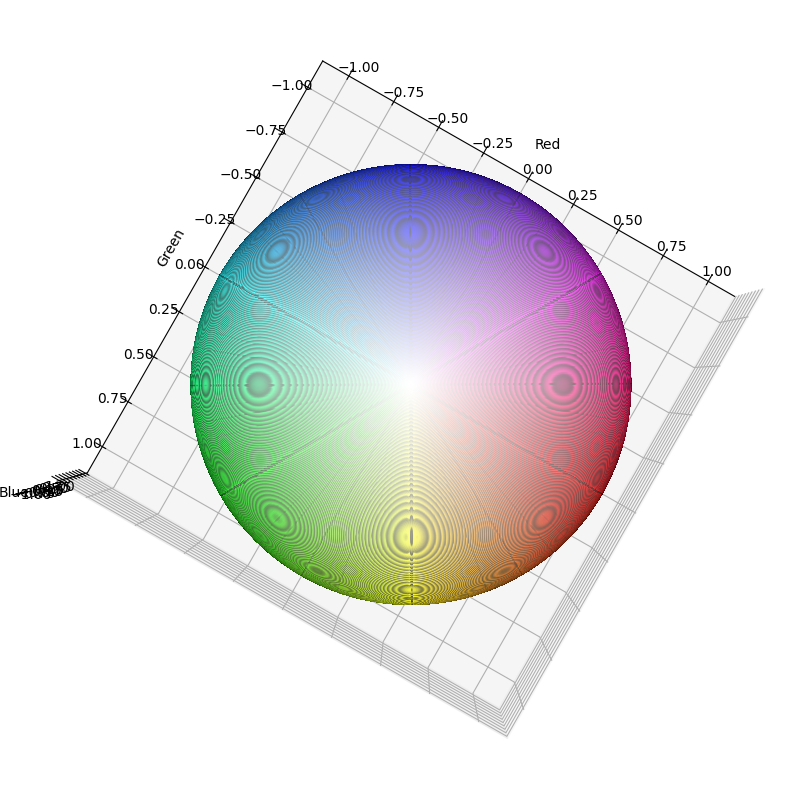

Thus, 16777216


In [33]:
class RGBMapping3DS:
    def __init__(self, color_index, color_list):
        self.color_index = np.array(color_index)
        self.color_list = np.array(color_list)

    def plot_points(self):
        fig = plt.figure(figsize=(14,10))
        ax = fig.add_subplot(111, projection='3d')

        # RGB values to coordinates
        points = self.color_list
        colors = self.color_index / 255

        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, marker='o')
        ax.view_init(270, 60)
        ax.set_xlabel('Red')
        ax.set_ylabel('Green')
        ax.set_zlabel('Blue')

        plt.show()

rgb_mapping_3d_south = RGBMapping3DS(color_index_unique, color_list_unique)

# Plot coordinates
rgb_mapping_3d_south.plot_points()
print("Thus,", len(color_index_unique))

In [47]:
class RGBMapping3D_side:
    def __init__(self, color_index, color_list):
        self.color_index = np.array(color_index)
        self.color_list = np.array(color_list)

    def plot_points(self):
        fig = plt.figure(figsize=(14,10))
        ax = fig.add_subplot(111, projection='3d')

        # RGB 값에 해당하는 좌표를 점으로 플로팅
        points = self.color_list
        colors = self.color_index / 255

        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, marker='o')
        ax.view_init(0,270)
        ax.set_xlabel('Red')
        ax.set_ylabel('Green')
        ax.set_zlabel('Blue')

        plt.show()

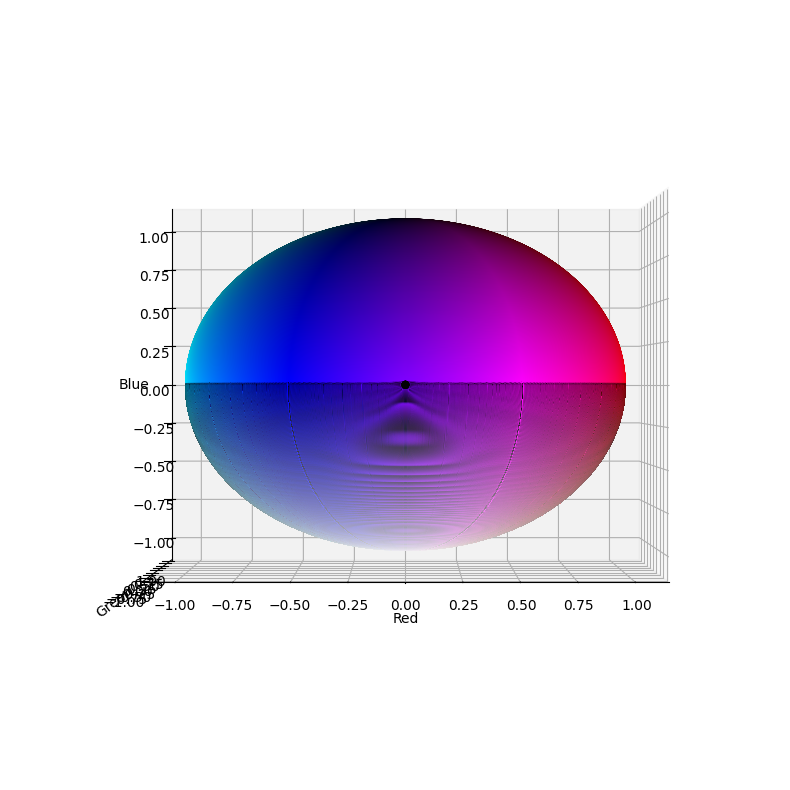

In [48]:
rgb_mapping_3d_side = RGBMapping3D_side(color_index_unique, color_list_unique)

# Plot coordinates
rgb_mapping_3d_side.plot_points()

위 그림과 같이 Bloch Sphere로 표현된 RGB 값의 좌표를 회로에 설계하여 측정한 다음,
State의 coefficient를 사용하여 계산하면 원래 RGB 값을 추론할 수 있다

또한 Look-Up-Table을 통해 해당 x,y,z 값을 갖는 RGB 값을 찾아보면 처음에 매핑한 RGB 값을 찾을 수 있다.

# Example

#### RGB = [200,100,0]

In [19]:
n = 200
k = 100

start = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [200,100,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots=200000)
job = aer_sim.run(qobj)
result = job.result()
counts = result.get_counts()

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(phi):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        phi = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(phi*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color = []
for i in range(len(pixel_color_phi_recon)):
    n_recon = pixel_color_theta_recon[i] * 1020 / np.pi
    k_recon = pixel_color_phi_recon[i] * 6 * n_recon / np.pi
    if phi <= 0.5236:
        recon_color.append(np.array([n_recon,k_recon,0]))
    elif 0.5236 < phi <= 0.5236*2:
        recon_color.append(np.array([n_recon-k_recon,n_recon,0]))
    elif 0.5236*2 < phi <= 0.5236*3:
        recon_color.append(np.array([0,n_recon,k_recon]))
    elif 0.5236*3 < phi <= 0.5236*4:
        recon_color.append(np.array([0,n_recon-k_recon,n_recon]))
    elif 0.5236*4 < phi <= 0.5236*5:
        recon_color.append(np.array([k_recon,0,n_recon]))
    elif 0.5236*5 < phi <= 0.5236*6:
        recon_color.append(np.array([n_recon,0,n_recon-k_recon]))



end = time.time()
time_simul = end - start
print(f'{time_simul:.5f}', "s")
print(recon_color)
print(pixel_color_theta_recon[0])
print(pixel_color_phi_recon[0])
'''
recon_color_index = recon_color[0]
fig = plt.figure()
ax = fig.add_subplot(111)
colors = recon_color_index / 255
ax.scatter(1,1,c=colors, marker='o')
ax.set_xlabel('Red')
ax.set_ylabel('Green')
'''

C:\Users\HCI\AppData\Local\Temp\ipykernel_4076\587386394.py:30: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


0.34613 s
[array([200.56415413, 100.60041356,   0.        ])]
0.6177361501840998
0.26263044657819445


"\nrecon_color_index = recon_color[0]\nfig = plt.figure()\nax = fig.add_subplot(111)\ncolors = recon_color_index / 255\nax.scatter(1,1,c=colors, marker='o')\nax.set_xlabel('Red')\nax.set_ylabel('Green')\n"

In [20]:
counts

{'00': 98258, '10': 90785, '11': 9243, '01': 1714}

In [21]:
counts_qiskit = {'|10>': 90785/200000, '|00>': 98258/200000, '|11>': 9243/200000, '|01>': 1714/200000}

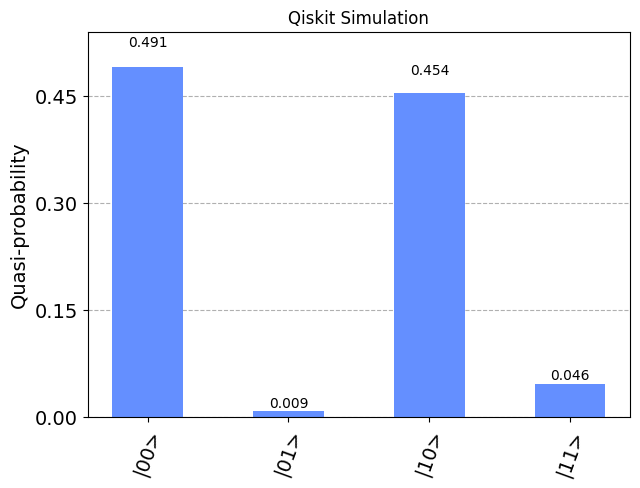

In [22]:
plot_histogram(counts_qiskit,title="Qiskit Simulation")

In [42]:
n = 200
k = 100
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi_origin = round(np.arctan2(y,x),4) / 2
theta_origin = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [200,100,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta_origin,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi_origin,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

phi_err = []
theta_err = []
total_err = []
recon_color_list = []
recon_color_err = []
delta_color = []
for iter in range(501):
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc, shots=200*(iter+500))
    job = aer_sim.run(qobj)
    result = job.result()
    counts = result.get_counts()
    pixel_color_theta_recon = []
    pixel_color_phi_recon = []

    pixel_color_theta = []
    pixel_color_phi = []

    for i in range(0, 1):
        for item in counts.items():
            key = item[0]
            amount = item[1]
            state = key[-1]
            decision = int(key[0])
            bin_coord = key[1:-1]

            if decision == 1:
                pixel_color_theta.append((state, amount))
            elif decision == 0:
                pixel_color_phi.append((state, amount))

    # ======================== phi ====================================
    total_phi_value = 0
    for state in pixel_color_phi:
        state_value = state[1]
        total_phi_value += state_value

    phi_state_0 = []
    for phi, amount in pixel_color_phi:
        if not int(phi):
            phi_state_0.append((phi, amount))

    for i in range(1):
        try:
            phi = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
            pixel_color_phi_recon.append(phi*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")
    # ======================== theta ====================================

    total_theta_value = 0
    for state in pixel_color_theta:
        state_value = state[1]
        total_theta_value += state_value

    theta_state_0 = []
    for theta, amount in pixel_color_theta:
        if not int(theta):
            theta_state_0.append((theta, amount))

    for i in range(1):
        try:
            theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
            pixel_color_theta_recon.append(theta*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")

    recon_color = []
    for i in range(len(pixel_color_phi_recon)):
        n_recon = round(pixel_color_theta_recon[i] * 1020 / np.pi,5)
        k_recon = round(pixel_color_phi_recon[i] * 6 * n_recon / np.pi,5)

        if phi <= 0.5236:
            recon_color.append(np.array([n_recon,k_recon,0]))
        ''''
        elif 0.5236 < phi <= 0.5236*2:
            recon_color.append(np.array([n_recon-k_recon,n_recon,0]))
        elif 0.5236*2 < phi <= 0.5236*3:
            recon_color.append(np.array([0,n_recon,k_recon]))
        elif 0.5236*3 < phi <= 0.5236*4:
            recon_color.append(np.array([0,n_recon-k_recon,n_recon]))
        elif 0.5236*4 < phi <= 0.5236*5:
            recon_color.append(np.array([k_recon,0,n_recon]))
        elif 0.5236*5 < phi <= 0.5236*6:
            recon_color.append(np.array([n_recon,0,n_recon-k_recon]))
        '''

    print("iteration = ",(iter+500)*200)
    print("phi_recon = ",pixel_color_phi_recon[0])
    print("theta_recon = ",pixel_color_theta_recon[0])

    phi_err.append(abs(pixel_color_phi_recon[0]-phi_origin))
    
    theta_err.append(abs(pixel_color_theta_recon[0]-theta_origin))
    total_err.append(abs(pixel_color_phi_recon[0]-phi_origin) + abs(pixel_color_theta_recon[0]-theta_origin))
    recon_color_list.append(recon_color)
    recon_color_err.append(abs(list(recon_color[0])[0]-200)+abs(list(recon_color[0])[1]-100))
    delta_color.append([round(list(recon_color[0])[0]-200,5),round(list(recon_color[0])[1]-100,5),0])
    print("Reconstructed color = ",recon_color)
    print("Delta Color r= ",delta_color)
    print("Color Error = ",abs(list(recon_color[0])[0]-200)+abs(list(recon_color[0])[1]-100))
    print("==========================================================================")

print("phi_err = ", phi_err)
print("theta_err = ",theta_err)

C:\Users\HCI\AppData\Local\Temp\ipykernel_4076\3835191188.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


iteration =  100000
phi_recon =  0.2607847779773032
theta_recon =  0.6116890732649166
Reconstructed color =  [array([198.60081,  98.91556,   0.     ])]
Delta Color r=  [[-1.39919, -1.08444, 0]]
Color Error =  2.483630000000005
iteration =  100200
phi_recon =  0.26942924697839465
theta_recon =  0.6126810034325854
Reconstructed color =  [array([198.92287, 102.36013,   0.     ])]
Delta Color r=  [[-1.39919, -1.08444, 0], [-1.07713, 2.36013, 0]]
Color Error =  3.437260000000009
iteration =  100400
phi_recon =  0.2647991131661073
theta_recon =  0.6140349873558019
Reconstructed color =  [array([199.36248, 100.8234 ,   0.     ])]
Delta Color r=  [[-1.39919, -1.08444, 0], [-1.07713, 2.36013, 0], [-0.63752, 0.8234, 0]]
Color Error =  1.4609200000000016
iteration =  100600
phi_recon =  0.25964525369819996
theta_recon =  0.6161975320872175
Reconstructed color =  [array([200.0646 ,  99.20922,   0.     ])]
Delta Color r=  [[-1.39919, -1.08444, 0], [-1.07713, 2.36013, 0], [-0.63752, 0.8234, 0], [0.0

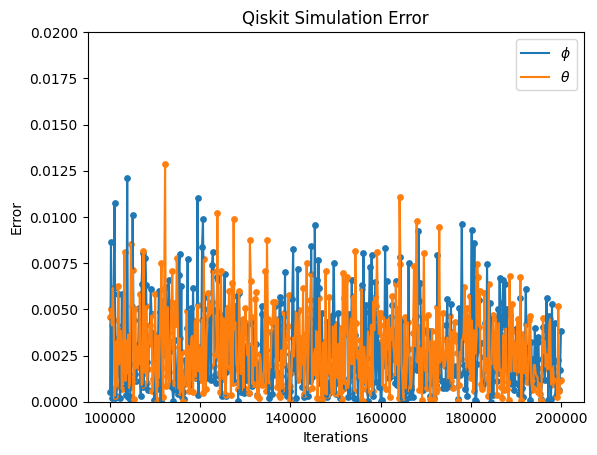

In [51]:
iters = []
for iter in range(501):
    iters.append((iter+500)*200)

plt.title("Qiskit Simulation Error")
plt.scatter(iters,phi_err,s=15)
plt.scatter(iters,theta_err,s=15)
plt.plot(iters,phi_err, label = "$\phi$")
plt.plot(iters,theta_err, label="$\\theta$")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.ylim(0,0.01)
plt.legend()
plt.show()


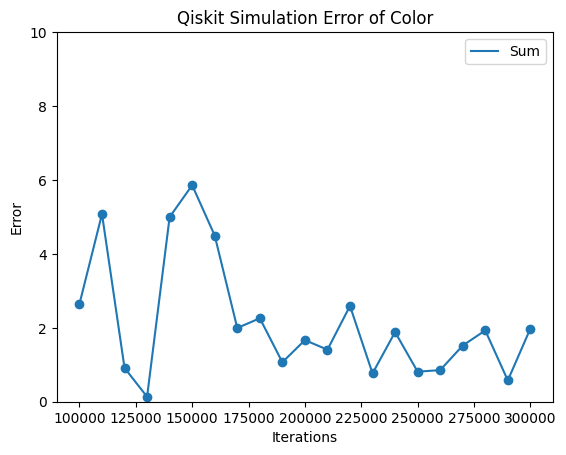

In [165]:
plt.title("Qiskit Simulation Error of Color")
plt.scatter(iters,recon_color_err, s = 36)
plt.plot(iters,recon_color_err, label = "Sum")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.ylim(0,10)
plt.legend()
plt.show()

In [ ]:
n = 200
k = 100
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi_origin = round(np.arctan2(y,x),4) / 2
theta_origin = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [200,100,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta_origin,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi_origin,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

phi_err_1000 = []
theta_err_1000 = []
total_err_1000 = []
recon_color_list = []
recon_color_err = []
delta_color = []
for iter in range(1001):
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc, shots=100*(iter+10))
    job = aer_sim.run(qobj)
    result = job.result()
    counts = result.get_counts()
    pixel_color_theta_recon = []
    pixel_color_phi_recon = []

    pixel_color_theta = []
    pixel_color_phi = []

    for i in range(0, 1):
        for item in counts.items():
            key = item[0]
            amount = item[1]
            state = key[-1]
            decision = int(key[0])
            bin_coord = key[1:-1]

            if decision == 1:
                pixel_color_theta.append((state, amount))
            elif decision == 0:
                pixel_color_phi.append((state, amount))

    # ======================== phi ====================================
    total_phi_value = 0
    for state in pixel_color_phi:
        state_value = state[1]
        total_phi_value += state_value

    phi_state_0 = []
    for phi, amount in pixel_color_phi:
        if not int(phi):
            phi_state_0.append((phi, amount))

    for i in range(1):
        try:
            phi = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
            pixel_color_phi_recon.append(phi*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")
    # ======================== theta ====================================

    total_theta_value = 0
    for state in pixel_color_theta:
        state_value = state[1]
        total_theta_value += state_value

    theta_state_0 = []
    for theta, amount in pixel_color_theta:
        if not int(theta):
            theta_state_0.append((theta, amount))

    for i in range(1):
        try:
            theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
            pixel_color_theta_recon.append(theta*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")

    recon_color = []
    for i in range(len(pixel_color_phi_recon)):
        n_recon = round(pixel_color_theta_recon[i] * 1020 / np.pi,5)
        k_recon = round(pixel_color_phi_recon[i] * 6 * n_recon / np.pi,5)

        if phi <= 0.5236:
            recon_color.append(np.array([n_recon,k_recon,0]))
        ''''
        elif 0.5236 < phi <= 0.5236*2:
            recon_color.append(np.array([n_recon-k_recon,n_recon,0]))
        elif 0.5236*2 < phi <= 0.5236*3:
            recon_color.append(np.array([0,n_recon,k_recon]))
        elif 0.5236*3 < phi <= 0.5236*4:
            recon_color.append(np.array([0,n_recon-k_recon,n_recon]))
        elif 0.5236*4 < phi <= 0.5236*5:
            recon_color.append(np.array([k_recon,0,n_recon]))
        elif 0.5236*5 < phi <= 0.5236*6:
            recon_color.append(np.array([n_recon,0,n_recon-k_recon]))
        '''

    print("iteration = ",(iter+500)*200)
    print("phi_recon = ",pixel_color_phi_recon[0])
    print("theta_recon = ",pixel_color_theta_recon[0])

    phi_err_1000.append(abs(pixel_color_phi_recon[0]-phi_origin))
    
    theta_err_1000.append(abs(pixel_color_theta_recon[0]-theta_origin))
    total_err_1000.append(abs(pixel_color_phi_recon[0]-phi_origin) + abs(pixel_color_theta_recon[0]-theta_origin))
    recon_color_list.append(recon_color)
    recon_color_err.append(abs(list(recon_color[0])[0]-200)+abs(list(recon_color[0])[1]-100))
    delta_color.append([round(list(recon_color[0])[0]-200,5),round(list(recon_color[0])[1]-100,5),0])
    print("Reconstructed color = ",recon_color)
    print("Delta Color r= ",delta_color)
    print("Color Error = ",abs(list(recon_color[0])[0]-200)+abs(list(recon_color[0])[1]-100))
    print("==========================================================================")

print("phi_err = ", phi_err_1000)
print("theta_err = ",theta_err_1000)

# IonQ

In [10]:
from qiskit_ionq import IonQProvider
provider = IonQProvider("api")

In [47]:
n = 200
k = 100
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi_origin = round(np.arctan2(y,x),4) / 2
theta_origin = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [200,100,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta_origin,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi_origin,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

phi_err = []
theta_err = []
total_err = []
recon_color_list = []
recon_color_err = []
delta_color = []
for iter in range(501):
    ionq_sim = provider.get_backend("ionq_simulator")
    t_qc_image = transpile(qc, ionq_sim)
    job_ionq = ionq_sim.run(t_qc_image, shots=200*(iter+500))
    result_ionq = job_ionq.result()
    counts = result_ionq.get_counts()

    pixel_color_theta_recon = []
    pixel_color_phi_recon = []

    pixel_color_theta = []
    pixel_color_phi = []

    for i in range(0, 1):
        for item in counts.items():
            key = item[0]
            amount = item[1]
            state = key[-1]
            decision = int(key[0])
            bin_coord = key[1:-1]

            if decision == 1:
                pixel_color_theta.append((state, amount))
            elif decision == 0:
                pixel_color_phi.append((state, amount))

    # ======================== phi ====================================
    total_phi_value = 0
    for state in pixel_color_phi:
        state_value = state[1]
        total_phi_value += state_value

    phi_state_0 = []
    for phi, amount in pixel_color_phi:
        if not int(phi):
            phi_state_0.append((phi, amount))

    for i in range(1):
        try:
            phi = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
            pixel_color_phi_recon.append(phi*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")
    # ======================== theta ====================================

    total_theta_value = 0
    for state in pixel_color_theta:
        state_value = state[1]
        total_theta_value += state_value

    theta_state_0 = []
    for theta, amount in pixel_color_theta:
        if not int(theta):
            theta_state_0.append((theta, amount))

    for i in range(1):
        try:
            theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
            pixel_color_theta_recon.append(theta*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")

    recon_color = []
    for i in range(len(pixel_color_phi_recon)):
        n_recon = round(pixel_color_theta_recon[i] * 1020 / np.pi,5)
        k_recon = round(pixel_color_phi_recon[i] * 6 * n_recon / np.pi,5)

        if phi <= 0.5236:
            recon_color.append(np.array([n_recon,k_recon,0]))
        ''''
        elif 0.5236 < phi <= 0.5236*2:
            recon_color.append(np.array([n_recon-k_recon,n_recon,0]))
        elif 0.5236*2 < phi <= 0.5236*3:
            recon_color.append(np.array([0,n_recon,k_recon]))
        elif 0.5236*3 < phi <= 0.5236*4:
            recon_color.append(np.array([0,n_recon-k_recon,n_recon]))
        elif 0.5236*4 < phi <= 0.5236*5:
            recon_color.append(np.array([k_recon,0,n_recon]))
        elif 0.5236*5 < phi <= 0.5236*6:
            recon_color.append(np.array([n_recon,0,n_recon-k_recon]))
        '''

    print("iteration = ",(iter+500)*200)
    print("phi_recon = ",pixel_color_phi_recon[0])
    print("theta_recon = ",pixel_color_theta_recon[0])

    phi_err.append(abs(pixel_color_phi_recon[0]-phi_origin))
    theta_err.append(abs(pixel_color_theta_recon[0]-theta_origin))
    total_err.append(abs(pixel_color_phi_recon[0]-phi_origin) + abs(pixel_color_theta_recon[0]-theta_origin))
    recon_color_list.append(recon_color)
    recon_color_err.append(abs(list(recon_color[0])[0]-200)+abs(list(recon_color[0])[1]-100))
    delta_color.append([round(list(recon_color[0])[0]-200,5),round(list(recon_color[0])[1]-100,5),0])
    print("Reconstructed color = ",recon_color)

    print("Color Error = ",abs(list(recon_color[0])[0]-200)+abs(list(recon_color[0])[1]-100))
    print("==========================================================================")
print("Delta Color r= ",delta_color)
print("phi_err = ", phi_err)
print("theta_err = ",theta_err)

iteration =  100000
phi_recon =  0.26231535579976656
theta_recon =  0.6114270031410272
Reconstructed color =  [array([198.51572,  99.45348,   0.     ])]
Color Error =  2.0308000000000135
iteration =  100200
phi_recon =  0.25313353950596984
theta_recon =  0.6210199853001968
Reconstructed color =  [array([201.63034,  97.47808,   0.     ])]
Color Error =  4.152259999999984
iteration =  100400
phi_recon =  0.2619792261010038
theta_recon =  0.620131252602261
Reconstructed color =  [array([201.34179, 100.74005,   0.     ])]
Color Error =  2.0818399999999997
iteration =  100600
phi_recon =  0.26531153789779194
theta_recon =  0.6221494092429776
Reconstructed color =  [array([201.99703, 102.35345,   0.     ])]
Color Error =  4.35047999999999
iteration =  100800
phi_recon =  0.2556477449226124
theta_recon =  0.6204069304274049
Reconstructed color =  [array([201.43129,  98.34907,   0.     ])]
Color Error =  3.0822199999999924
iteration =  101000
phi_recon =  0.27255105313289496
theta_recon =  0.6

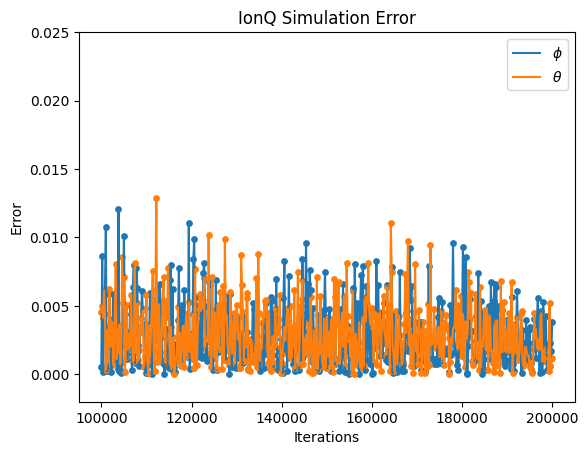

In [48]:
iters = []
for iter in range(501):
    iters.append((iter+500)*200)

plt.title("IonQ Simulation Error")
plt.scatter(iters,phi_err,s=15)
plt.scatter(iters,theta_err,s=15)
plt.plot(iters,phi_err, label = "$\phi$")
plt.plot(iters,theta_err, label="$\\theta$")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.ylim(-0.002,0.025)
plt.legend()
plt.show()

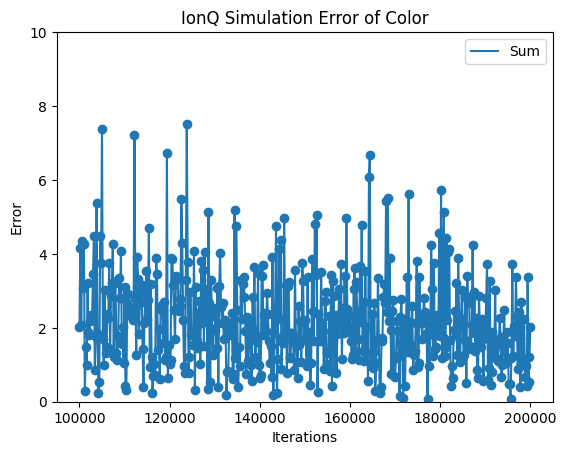

In [49]:
plt.title("IonQ Simulation Error of Color")
plt.scatter(iters,recon_color_err, s = 36)
plt.plot(iters,recon_color_err, label = "Sum")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.ylim(0,10)
plt.legend()
plt.show()

In [31]:
counts.items()

dict_items([('10', 90695), ('00', 98419), ('11', 9155), ('01', 1731)])

In [19]:
counts_simul_prob = {'|11>': 9155/200000, '|10>': 90695/200000, '|00>': 98419/200000, '|01>': 1731/200000}

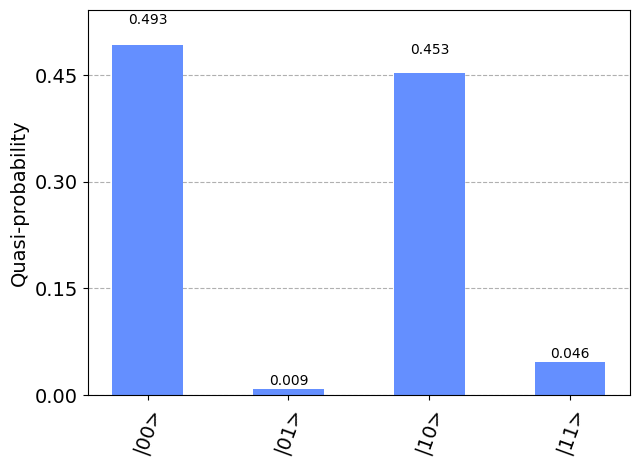

In [20]:
plot_histogram(counts_simul_prob)

In [45]:
error = []
for i in range(1):
    del_x = recon_color[0][0] - n
    del_y = recon_color[0][1] - k
    err = np.sqrt(del_x**2+del_y**2)
    error.append(err)

print("error = ",error,"time = ", time_simul)

error =  [3.1722207109397123] time =  0.380831241607666


In [36]:
n = 200
k = 100

start = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [200,100,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

ionq_sim = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc, ionq_sim)
job = ionq_sim.run(t_qc_image, shots=200000)
result = job.result()
counts = result.get_counts()

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(phi):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        phi = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(phi*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color = []
for i in range(len(pixel_color_phi_recon)):
    n_recon = pixel_color_theta_recon[i] * 1020 / np.pi
    k_recon = pixel_color_phi_recon[i] * 6 * n_recon / np.pi
    if phi <= 0.5236:
        recon_color.append(np.array([n_recon,k_recon,0]))
    elif 0.5236 < phi <= 0.5236*2:
        recon_color.append(np.array([n_recon-k_recon,n_recon,0]))
    elif 0.5236*2 < phi <= 0.5236*3:
        recon_color.append(np.array([0,n_recon,k_recon]))
    elif 0.5236*3 < phi <= 0.5236*4:
        recon_color.append(np.array([0,n_recon-k_recon,n_recon]))
    elif 0.5236*4 < phi <= 0.5236*5:
        recon_color.append(np.array([k_recon,0,n_recon]))
    elif 0.5236*5 < phi <= 0.5236*6:
        recon_color.append(np.array([n_recon,0,n_recon-k_recon]))



end = time.time()
time_simul = end - start
print(f'{time_simul:.5f}', "s")
print(recon_color)
print(pixel_color_theta_recon[0])
print(pixel_color_phi_recon[0])

9.80929 s
[array([200.08784408,  99.64758765,   0.        ])]
0.6162691186536512
0.26076224233780027


In [32]:
counts

{'00': 98272, '01': 1691, '10': 90961, '11': 9076}

In [33]:
counts_simul = {'|00>': 98272/200000, '|01>': 1691/200000, '|10>': 90961/200000, '|11>': 9076/200000}

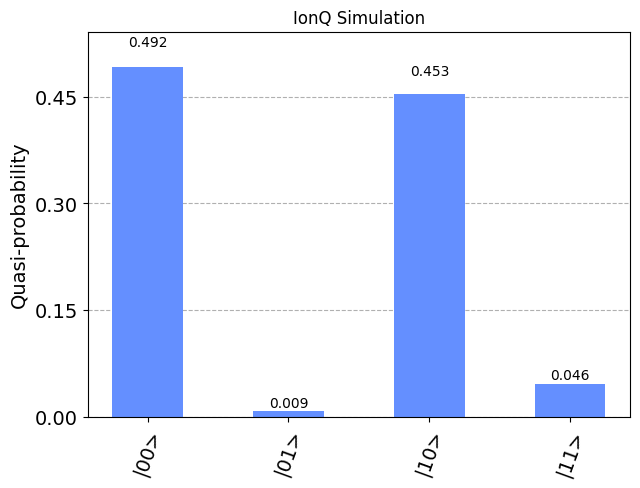

In [28]:
plot_histogram(counts_simul, title ="IonQ Simulation")

In [254]:
counts_ = {'|00>': 0.49177, '|01>': 0.0826, '|10>': 0.45429, '|11>': 0.04568}

{'00': 49177, '01': 826, '10': 45429, '11': 4568}

C:\Users\HCI\AppData\Local\Temp\ipykernel_12944\2898810973.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1,1,c=colors, marker='o')


Text(0, 0.5, 'Green')

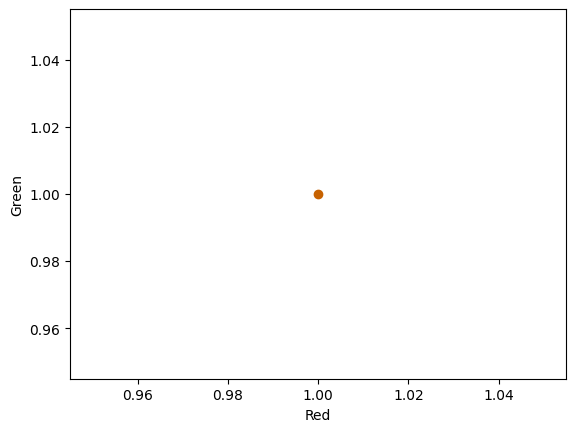

In [253]:
recon_color_index = recon_color[0]
fig = plt.figure()
ax = fig.add_subplot(111)
colors = recon_color_index / 255
ax.scatter(1,1,c=colors, marker='o')
ax.set_xlabel('Red')
ax.set_ylabel('Green')

In [255]:
n = 200
k = 100

start = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [200,100,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

ionq_sim = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc, ionq_sim)
job = ionq_sim.run(t_qc_image, shots=200000)
result = job.result()
counts = result.get_counts()

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(phi):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        phi = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(phi*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color = []
for i in range(len(pixel_color_phi_recon)):
    n_recon = pixel_color_theta_recon[i] * 1020 / np.pi
    k_recon = pixel_color_phi_recon[i] * 6 * n_recon / np.pi
    if phi <= 0.5236:
        recon_color.append(np.array([n_recon,k_recon,0]))
    elif 0.5236 < phi <= 0.5236*2:
        recon_color.append(np.array([n_recon-k_recon,n_recon,0]))
    elif 0.5236*2 < phi <= 0.5236*3:
        recon_color.append(np.array([0,n_recon,k_recon]))
    elif 0.5236*3 < phi <= 0.5236*4:
        recon_color.append(np.array([0,n_recon-k_recon,n_recon]))
    elif 0.5236*4 < phi <= 0.5236*5:
        recon_color.append(np.array([k_recon,0,n_recon]))
    elif 0.5236*5 < phi <= 0.5236*6:
        recon_color.append(np.array([n_recon,0,n_recon-k_recon]))



end = time.time()
time_simul = end - start
print(f'{time_simul:.5f}', "s")
print(recon_color)


8.62378 s
[array([198.84198457,  98.8291607 ,   0.        ])]


In [268]:
counts_re = {'|00>': 0.97931, '|01>': 0.01677, '|10>': 0.91269, '|11>': 0.09123}

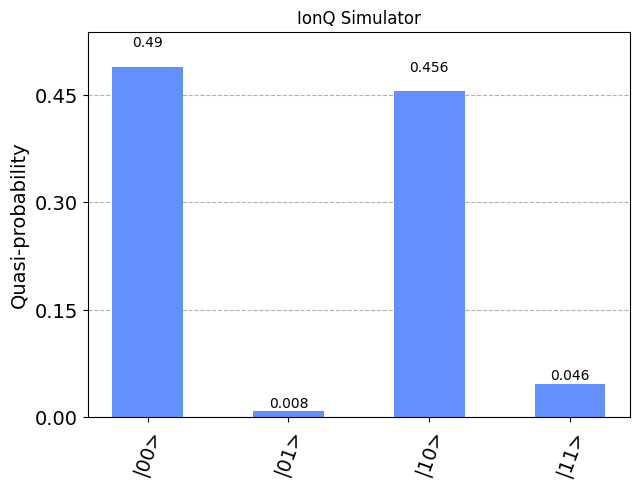

In [276]:
plot_histogram(counts_re, title ="IonQ Simulator")

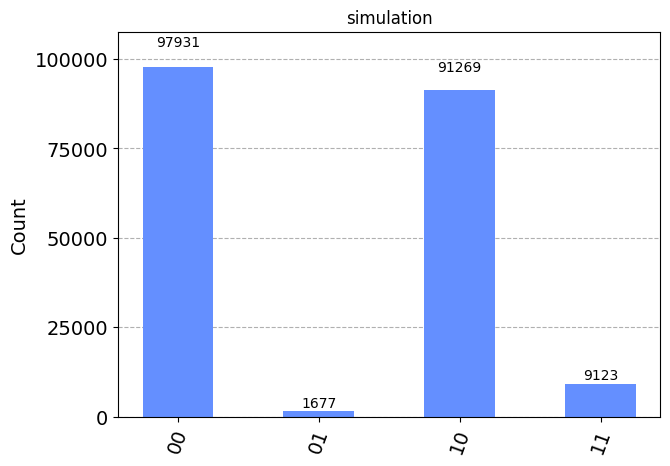

In [257]:
plot_histogram(counts, title ="simulation")

In [225]:
ionq_result={"|00>":0.4816,"|01>":0.0178,"|10>":0.4438,"|11>":0.0568}

In [224]:
counts_renew = {'|00>': 0.98150, '|01>': 0.1758, '|10>': 0.90728, '|11>': 0.09364}

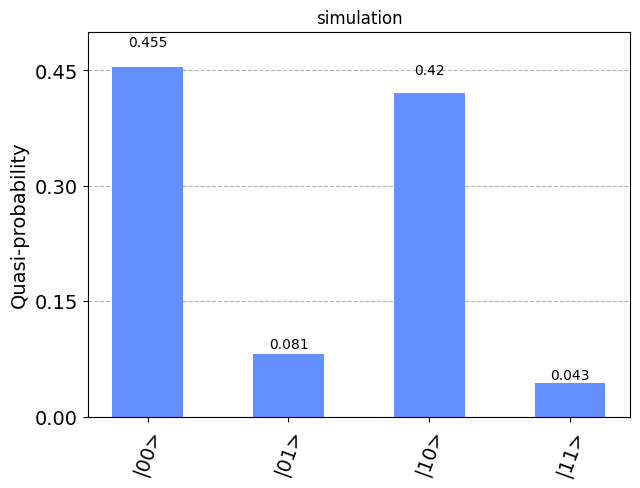

In [239]:
plot_histogram(counts_renew, title ="simulation",)

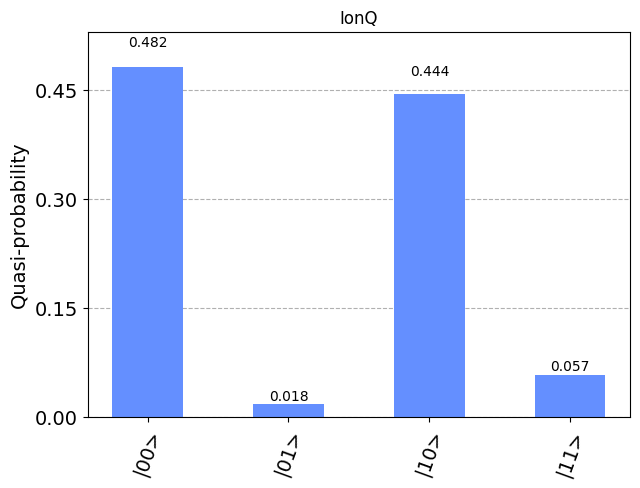

In [248]:
plot_histogram(ionq_result, title ="IonQ",)

In [249]:
n = 200
k = 100

start_ionq = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
print(theta)
print(phi)

0.616
0.2618


In [270]:
n = 200
k = 100

start = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [200,100,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc, aer_sim)
qobj = assemble(t_qc_image, shots=200000)
job = aer_sim.run(qobj)
result = job.result()
counts = result.get_counts()

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(phi):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        phi = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(phi*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color = []
for i in range(len(pixel_color_phi_recon)):
    n_recon = pixel_color_theta_recon[i] * 1020 / np.pi
    k_recon = pixel_color_phi_recon[i] * 6 * n_recon / np.pi
    if phi <= 0.5236:
        recon_color.append(np.array([n_recon,k_recon,0]))
    elif 0.5236 < phi <= 0.5236*2:
        recon_color.append(np.array([n_recon-k_recon,n_recon,0]))
    elif 0.5236*2 < phi <= 0.5236*3:
        recon_color.append(np.array([0,n_recon,k_recon]))
    elif 0.5236*3 < phi <= 0.5236*4:
        recon_color.append(np.array([0,n_recon-k_recon,n_recon]))
    elif 0.5236*4 < phi <= 0.5236*5:
        recon_color.append(np.array([k_recon,0,n_recon]))
    elif 0.5236*5 < phi <= 0.5236*6:
        recon_color.append(np.array([n_recon,0,n_recon-k_recon]))



end = time.time()
time_simul = end - start
print(f'{time_simul:.5f}', "s")
print(recon_color)


C:\Users\HCI\AppData\Local\Temp\ipykernel_12944\3034943071.py:30: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


0.73403 s
[array([199.92496796,  99.52428075,   0.        ])]


In [272]:
counts

{'00': 98434, '10': 90703, '11': 9172, '01': 1691}

In [274]:
counts_aer = {'|00>': 0.98434, '|10>': 0.90703, '|11>': 0.09172, '|01>': 0.01691}

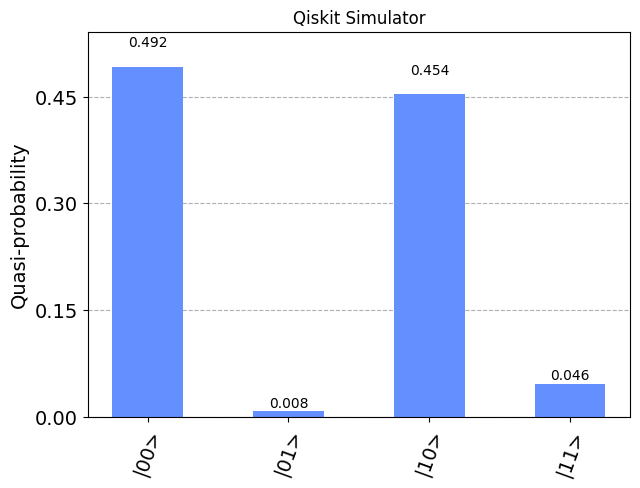

In [275]:
plot_histogram(counts_aer, title = "Qiskit Simulator")

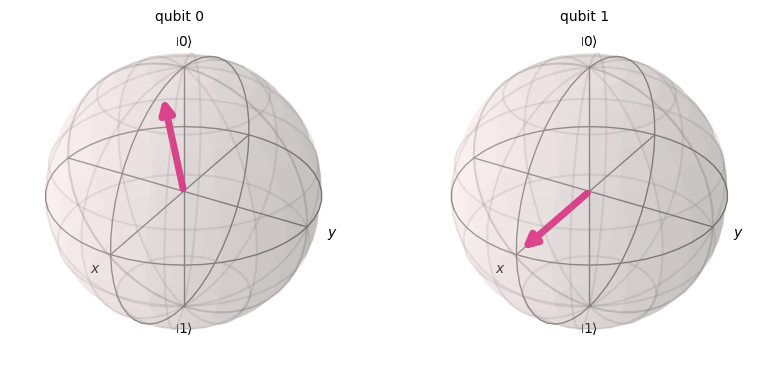

In [251]:
c_reg = QuantumRegister(1,name='q1')
color = QuantumRegister(1, name='q2')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
state = Statevector.from_instruction(qc)
plot_bloch_multivector(state)

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


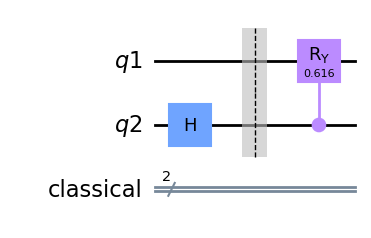

In [247]:
qc.draw('mpl')

In [64]:
n = 200
k = 100

start_ionq = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [200,100,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

ionq_sim = provider.get_backend("ionq_qpu.harmony")
t_qc_image = transpile(qc, ionq_sim)
job_ionq = ionq_sim.run(t_qc_image, shots=10000)
result_ionq = job_ionq.result()
counts_ionq = result_ionq.get_counts()

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts_ionq.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(theta):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        theta = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color_ionq = []
for i in range(len(pixel_color_phi_recon)):
    n_recon_ionq = pixel_color_theta_recon[i] * 1020 / np.pi
    k_recon_ionq = pixel_color_phi_recon[i] * 6 * n_recon_ionq / np.pi
    recon_color_ionq.append(np.array([n_recon_ionq,k_recon_ionq,0]))
end_ionq = time.time()
time_ionq = end_ionq -  start_ionq
print(f'{time_ionq:.5f}', "s")
print(recon_color_ionq)
recon_color__ionq_index = recon_color_ionq[0]
fig = plt.figure()
ax = fig.add_subplot(111)
colors_ionq = recon_color__ionq_index / 255
ax.scatter(1,1,c=colors_ionq, marker='o')
ax.set_xlabel('Red')
ax.set_ylabel('Green')

IonQAPIError: IonQAPIError(message='No error details provided.',status_code=530,headers={'Date': 'Thu, 04 Jul 2024 12:36:44 GMT', 'Content-Type': 'text/html; charset=UTF-8', 'Content-Length': '6168', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '89df299e2ea4f6ad-NRT'},body=<!DOCTYPE html>
<!--[if lt IE 7]> <html class="no-js ie6 oldie" lang="en-US"> <![endif]-->
<!--[if IE 7]>    <html class="no-js ie7 oldie" lang="en-US"> <![endif]-->
<!--[if IE 8]>    <html class="no-js ie8 oldie" lang="en-US"> <![endif]-->
<!--[if gt IE 8]><!--> <html class="no-js" lang="en-US"> <!--<![endif]-->
<head>
<title>Argo Tunnel error | api.ionq.co | Cloudflare</title>
<meta charset="UTF-8" />
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />
<meta http-equiv="X-UA-Compatible" content="IE=Edge" />
<meta name="robots" content="noindex, nofollow" />
<meta name="viewport" content="width=device-width,initial-scale=1" />
<link rel="stylesheet" id="cf_styles-css" href="/cdn-cgi/styles/main.css" />


<script>
(function(){if(document.addEventListener&&window.XMLHttpRequest&&JSON&&JSON.stringify){var e=function(a){var c=document.getElementById("error-feedback-survey"),d=document.getElementById("error-feedback-success"),b=new XMLHttpRequest;a={event:"feedback clicked",properties:{errorCode:1033,helpful:a,version:1}};b.open("POST","https://sparrow.cloudflare.com/api/v1/event");b.setRequestHeader("Content-Type","application/json");b.setRequestHeader("Sparrow-Source-Key","c771f0e4b54944bebf4261d44bd79a1e");
b.send(JSON.stringify(a));c.classList.add("feedback-hidden");d.classList.remove("feedback-hidden")};document.addEventListener("DOMContentLoaded",function(){var a=document.getElementById("error-feedback"),c=document.getElementById("feedback-button-yes"),d=document.getElementById("feedback-button-no");"classList"in a&&(a.classList.remove("feedback-hidden"),c.addEventListener("click",function(){e(!0)}),d.addEventListener("click",function(){e(!1)}))})}})();
</script>

<script defer src="https://performance.radar.cloudflare.com/beacon.js"></script>
</head>
<body>
  <div id="cf-wrapper">
    <div class="cf-alert cf-alert-error cf-cookie-error hidden" id="cookie-alert" data-translate="enable_cookies">Please enable cookies.</div>
    <div id="cf-error-details" class="p-0">
      <header class="mx-auto pt-10 lg:pt-6 lg:px-8 w-240 lg:w-full mb-15 antialiased">
         <h1 class="inline-block md:block mr-2 md:mb-2 font-light text-60 md:text-3xl text-black-dark leading-tight">
           <span data-translate="error">Error</span>
           <span>1033</span>
         </h1>
         <span class="inline-block md:block heading-ray-id font-mono text-15 lg:text-sm lg:leading-relaxed">Ray ID: 89df299e2ea4f6ad &bull;</span>
         <span class="inline-block md:block heading-ray-id font-mono text-15 lg:text-sm lg:leading-relaxed">2024-07-04 12:36:44 UTC</span>
        <h2 class="text-gray-600 leading-1.3 text-3xl lg:text-2xl font-light">Argo Tunnel error</h2>
      </header>

      <section class="w-240 lg:w-full mx-auto mb-8 lg:px-8">
          <div id="what-happened-section" class="w-1/2 md:w-full">
            <h2 class="text-3xl leading-tight font-normal mb-4 text-black-dark antialiased" data-translate="what_happened">What happened?</h2>
            <p>You've requested a page on a website (api.ionq.co) that is on the <a href="https://www.cloudflare.com/5xx-error-landing/" target="_blank">Cloudflare</a> network. The host (api.ionq.co) is configured as an Argo Tunnel, and Cloudflare is currently unable to resolve it.
            
          </div>

          
          <div id="resolution-copy-section" class="w-1/2 mt-6 text-15 leading-normal">
            <h2 class="text-3xl leading-tight font-normal mb-4 text-black-dark antialiased" data-translate="what_can_i_do">What can I do?</h2>
            <p><strong>If you are a visitor of this website:</strong><br />Please try again in a few minutes.</p><p><strong>If you are the owner of this website:</strong><br />Ensure that cloudflared is running and can reach the network. You may wish to enable <a rel="noopener noreferrer" href="https://developers.cloudflare.com/argo-tunnel/reference/load-balancing/">load balancing</a> for your tunnel.</p>
          </div>
          
      </section>

      <div class="feedback-hidden py-8 text-center" id="error-feedback">
    <div id="error-feedback-survey" class="footer-line-wrapper">
        Was this page helpful?
        <button class="border border-solid bg-white cf-button cursor-pointer ml-4 px-4 py-2 rounded" id="feedback-button-yes" type="button">Yes</button>
        <button class="border border-solid bg-white cf-button cursor-pointer ml-4 px-4 py-2 rounded" id="feedback-button-no" type="button">No</button>
    </div>
    <div class="feedback-success feedback-hidden" id="error-feedback-success">
        Thank you for your feedback!
    </div>
</div>


      <div class="cf-error-footer cf-wrapper w-240 lg:w-full py-10 sm:py-4 sm:px-8 mx-auto text-center sm:text-left border-solid border-0 border-t border-gray-300">
  <p class="text-13">
    <span class="cf-footer-item sm:block sm:mb-1">Cloudflare Ray ID: <strong class="font-semibold">89df299e2ea4f6ad</strong></span>
    <span class="cf-footer-separator sm:hidden">&bull;</span>
    <span id="cf-footer-item-ip" class="cf-footer-item hidden sm:block sm:mb-1">
      Your IP:
      <button type="button" id="cf-footer-ip-reveal" class="cf-footer-ip-reveal-btn">Click to reveal</button>
      <span class="hidden" id="cf-footer-ip">203.246.113.85</span>
      <span class="cf-footer-separator sm:hidden">&bull;</span>
    </span>
    <span class="cf-footer-item sm:block sm:mb-1"><span>Performance &amp; security by</span> <a rel="noopener noreferrer" href="https://www.cloudflare.com/5xx-error-landing" id="brand_link" target="_blank">Cloudflare</a></span>
    
  </p>
  <script>(function(){function d(){var b=a.getElementById("cf-footer-item-ip"),c=a.getElementById("cf-footer-ip-reveal");b&&"classList"in b&&(b.classList.remove("hidden"),c.addEventListener("click",function(){c.classList.add("hidden");a.getElementById("cf-footer-ip").classList.remove("hidden")}))}var a=document;document.addEventListener&&a.addEventListener("DOMContentLoaded",d)})();</script>
</div><!-- /.error-footer -->


    </div><!-- /#cf-error-details -->
  </div><!-- /#cf-wrapper -->

  <script>
  window._cf_translation = {};
  
  
</script>

</body>
</html>
,error_type='internal_error')

In [65]:
result_ionq = job_ionq.result()

IonQAPIError: IonQAPIError(message='No error details provided.',status_code=530,headers={'Date': 'Sun, 07 Jul 2024 04:01:29 GMT', 'Content-Type': 'text/html; charset=UTF-8', 'Content-Length': '6168', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '89f4eeff9c92f5c8-NRT'},body=<!DOCTYPE html>
<!--[if lt IE 7]> <html class="no-js ie6 oldie" lang="en-US"> <![endif]-->
<!--[if IE 7]>    <html class="no-js ie7 oldie" lang="en-US"> <![endif]-->
<!--[if IE 8]>    <html class="no-js ie8 oldie" lang="en-US"> <![endif]-->
<!--[if gt IE 8]><!--> <html class="no-js" lang="en-US"> <!--<![endif]-->
<head>
<title>Argo Tunnel error | api.ionq.co | Cloudflare</title>
<meta charset="UTF-8" />
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />
<meta http-equiv="X-UA-Compatible" content="IE=Edge" />
<meta name="robots" content="noindex, nofollow" />
<meta name="viewport" content="width=device-width,initial-scale=1" />
<link rel="stylesheet" id="cf_styles-css" href="/cdn-cgi/styles/main.css" />


<script>
(function(){if(document.addEventListener&&window.XMLHttpRequest&&JSON&&JSON.stringify){var e=function(a){var c=document.getElementById("error-feedback-survey"),d=document.getElementById("error-feedback-success"),b=new XMLHttpRequest;a={event:"feedback clicked",properties:{errorCode:1033,helpful:a,version:1}};b.open("POST","https://sparrow.cloudflare.com/api/v1/event");b.setRequestHeader("Content-Type","application/json");b.setRequestHeader("Sparrow-Source-Key","c771f0e4b54944bebf4261d44bd79a1e");
b.send(JSON.stringify(a));c.classList.add("feedback-hidden");d.classList.remove("feedback-hidden")};document.addEventListener("DOMContentLoaded",function(){var a=document.getElementById("error-feedback"),c=document.getElementById("feedback-button-yes"),d=document.getElementById("feedback-button-no");"classList"in a&&(a.classList.remove("feedback-hidden"),c.addEventListener("click",function(){e(!0)}),d.addEventListener("click",function(){e(!1)}))})}})();
</script>

<script defer src="https://performance.radar.cloudflare.com/beacon.js"></script>
</head>
<body>
  <div id="cf-wrapper">
    <div class="cf-alert cf-alert-error cf-cookie-error hidden" id="cookie-alert" data-translate="enable_cookies">Please enable cookies.</div>
    <div id="cf-error-details" class="p-0">
      <header class="mx-auto pt-10 lg:pt-6 lg:px-8 w-240 lg:w-full mb-15 antialiased">
         <h1 class="inline-block md:block mr-2 md:mb-2 font-light text-60 md:text-3xl text-black-dark leading-tight">
           <span data-translate="error">Error</span>
           <span>1033</span>
         </h1>
         <span class="inline-block md:block heading-ray-id font-mono text-15 lg:text-sm lg:leading-relaxed">Ray ID: 89f4eeff9c92f5c8 &bull;</span>
         <span class="inline-block md:block heading-ray-id font-mono text-15 lg:text-sm lg:leading-relaxed">2024-07-07 04:01:29 UTC</span>
        <h2 class="text-gray-600 leading-1.3 text-3xl lg:text-2xl font-light">Argo Tunnel error</h2>
      </header>

      <section class="w-240 lg:w-full mx-auto mb-8 lg:px-8">
          <div id="what-happened-section" class="w-1/2 md:w-full">
            <h2 class="text-3xl leading-tight font-normal mb-4 text-black-dark antialiased" data-translate="what_happened">What happened?</h2>
            <p>You've requested a page on a website (api.ionq.co) that is on the <a href="https://www.cloudflare.com/5xx-error-landing/" target="_blank">Cloudflare</a> network. The host (api.ionq.co) is configured as an Argo Tunnel, and Cloudflare is currently unable to resolve it.
            
          </div>

          
          <div id="resolution-copy-section" class="w-1/2 mt-6 text-15 leading-normal">
            <h2 class="text-3xl leading-tight font-normal mb-4 text-black-dark antialiased" data-translate="what_can_i_do">What can I do?</h2>
            <p><strong>If you are a visitor of this website:</strong><br />Please try again in a few minutes.</p><p><strong>If you are the owner of this website:</strong><br />Ensure that cloudflared is running and can reach the network. You may wish to enable <a rel="noopener noreferrer" href="https://developers.cloudflare.com/argo-tunnel/reference/load-balancing/">load balancing</a> for your tunnel.</p>
          </div>
          
      </section>

      <div class="feedback-hidden py-8 text-center" id="error-feedback">
    <div id="error-feedback-survey" class="footer-line-wrapper">
        Was this page helpful?
        <button class="border border-solid bg-white cf-button cursor-pointer ml-4 px-4 py-2 rounded" id="feedback-button-yes" type="button">Yes</button>
        <button class="border border-solid bg-white cf-button cursor-pointer ml-4 px-4 py-2 rounded" id="feedback-button-no" type="button">No</button>
    </div>
    <div class="feedback-success feedback-hidden" id="error-feedback-success">
        Thank you for your feedback!
    </div>
</div>


      <div class="cf-error-footer cf-wrapper w-240 lg:w-full py-10 sm:py-4 sm:px-8 mx-auto text-center sm:text-left border-solid border-0 border-t border-gray-300">
  <p class="text-13">
    <span class="cf-footer-item sm:block sm:mb-1">Cloudflare Ray ID: <strong class="font-semibold">89f4eeff9c92f5c8</strong></span>
    <span class="cf-footer-separator sm:hidden">&bull;</span>
    <span id="cf-footer-item-ip" class="cf-footer-item hidden sm:block sm:mb-1">
      Your IP:
      <button type="button" id="cf-footer-ip-reveal" class="cf-footer-ip-reveal-btn">Click to reveal</button>
      <span class="hidden" id="cf-footer-ip">203.246.113.85</span>
      <span class="cf-footer-separator sm:hidden">&bull;</span>
    </span>
    <span class="cf-footer-item sm:block sm:mb-1"><span>Performance &amp; security by</span> <a rel="noopener noreferrer" href="https://www.cloudflare.com/5xx-error-landing" id="brand_link" target="_blank">Cloudflare</a></span>
    
  </p>
  <script>(function(){function d(){var b=a.getElementById("cf-footer-item-ip"),c=a.getElementById("cf-footer-ip-reveal");b&&"classList"in b&&(b.classList.remove("hidden"),c.addEventListener("click",function(){c.classList.add("hidden");a.getElementById("cf-footer-ip").classList.remove("hidden")}))}var a=document;document.addEventListener&&a.addEventListener("DOMContentLoaded",d)})();</script>
</div><!-- /.error-footer -->


    </div><!-- /#cf-error-details -->
  </div><!-- /#cf-wrapper -->

  <script>
  window._cf_translation = {};
  
  
</script>

</body>
</html>
,error_type='internal_error')

In [8]:
n = 200
k = 100

start_ionq = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

In [9]:
counts_ionq = {"00":4816,"01":178,"10":4438,"11":568}
counts_ionq.items()

dict_items([('00', 4816), ('01', 178), ('10', 4438), ('11', 568)])

15.01905 s
[array([223.09333887, 161.85197892,   0.        ])]


C:\Users\HCI\AppData\Local\Temp\ipykernel_12944\2945423126.py:69: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1,1,c=colors_ionq, marker='o')


Text(0, 0.5, 'Green')

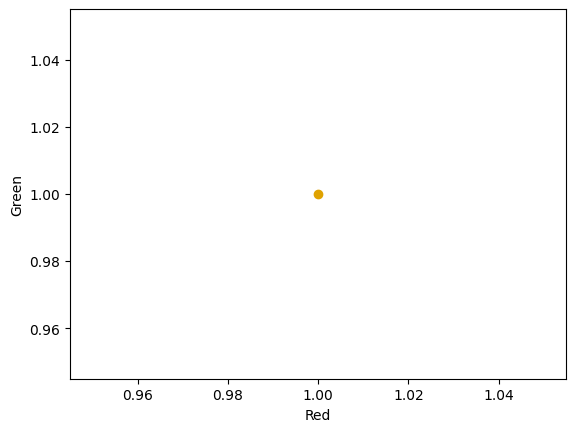

In [10]:
pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts_ionq.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(theta):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        theta = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color_ionq = []
for i in range(len(pixel_color_phi_recon)):
    n_recon_ionq = pixel_color_theta_recon[i] * 1020 / np.pi
    k_recon_ionq = pixel_color_phi_recon[i] * 6 * n_recon_ionq / np.pi
    recon_color_ionq.append(np.array([n_recon_ionq,k_recon_ionq,0]))
end_ionq = time.time()
time_ionq = end_ionq -  start_ionq
print(f'{time_ionq:.5f}', "s")
print(recon_color_ionq)
recon_color__ionq_index = recon_color_ionq[0]
fig = plt.figure()
ax = fig.add_subplot(111)
colors_ionq = recon_color__ionq_index / 255
ax.scatter(1,1,c=colors_ionq, marker='o')
ax.set_xlabel('Red')
ax.set_ylabel('Green')

In [17]:
np.sin(255*np.pi/510) * np.cos(255 * np.pi / (3 *255))

0.5000000000000001

In [18]:
np.sin(255*np.pi/510) * np.sin(255 * np.pi / (3 *255))

0.8660254037844386

In [ ]:
np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))

In [19]:
round(np.arctan2(0.86602,0.50000),4) / 2

0.5236

In [26]:
round(np.arccos(0),4) / 2

0.7854

8.72389 s
[array([253.24032584,   0.        ,   0.        ])]


C:\Users\HCI\AppData\Local\Temp\ipykernel_12944\4293659554.py:101: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1,1,c=colors_ionq, marker='o')


Text(0, 0.5, 'Green')

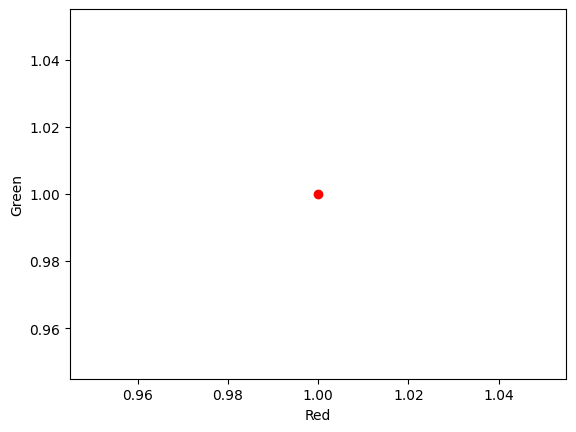

In [131]:
n = 255
k = 0

start_ionq = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [255,0,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

ionq_sim = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc, ionq_sim)
job_ionq = ionq_sim.run(t_qc_image, shots=200000)
result_ionq = job_ionq.result()
counts_ionq = result_ionq.get_counts()

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts_ionq.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(theta):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        theta = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color_ionq = []
for i in range(len(pixel_color_phi_recon)):
    n_recon_ionq = pixel_color_theta_recon[i] * 1020 / np.pi
    k_recon_ionq = pixel_color_phi_recon[i] * 6 * n_recon_ionq / np.pi
    recon_color_ionq.append(np.array([n_recon_ionq,k_recon_ionq,0]))
end_ionq = time.time()
time_ionq = end_ionq -  start_ionq
print(f'{time_ionq:.5f}', "s")
print(recon_color_ionq)
recon_color__ionq_index = recon_color_ionq[0]
fig = plt.figure()
ax = fig.add_subplot(111)
colors_ionq = recon_color__ionq_index / 255
ax.scatter(1,1,c=colors_ionq, marker='o')
ax.set_xlabel('Red')
ax.set_ylabel('Green')

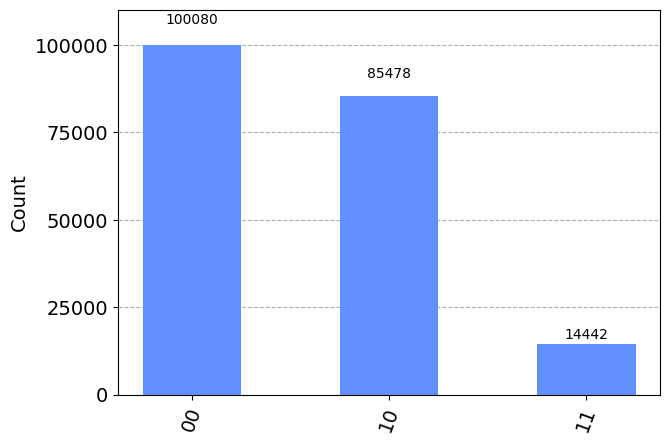

In [132]:
plot_histogram(counts_ionq)

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


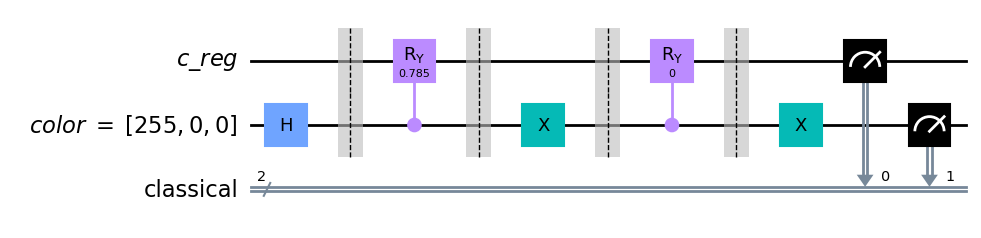

In [133]:
qc.draw('mpl')

In [149]:
c_reg = QuantumRegister(1,name='q1')
color = QuantumRegister(1, name='q2')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
#qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
#qc.cry(0,color,c_reg)
qc.barrier()
qc.x(1)

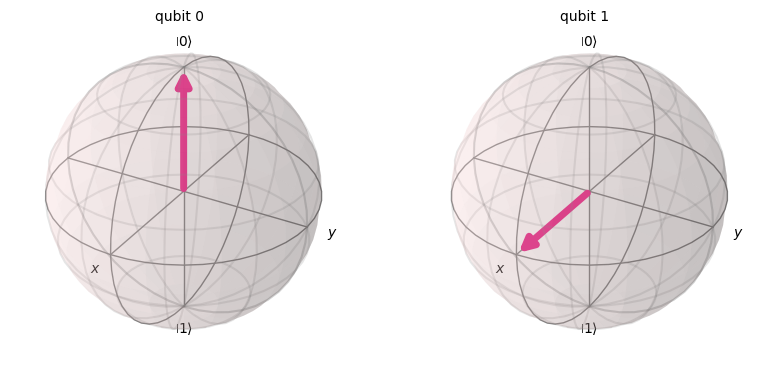

In [150]:
state = Statevector.from_instruction(qc)
plot_bloch_multivector(state)

C:\Users\HCI\AppData\Local\Temp\ipykernel_12944\1108092215.py:5: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


{'00': 100053, '10': 99947}


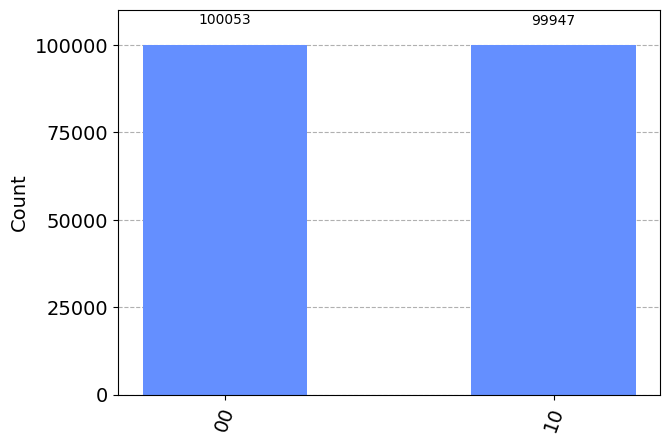

In [151]:
qc.measure([0,1],[0,1])
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc, aer_sim)
qobj = assemble(t_qc_image, shots=200000)
job = aer_sim.run(qobj)
result = job.result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)


C:\Users\HCI\AppData\Local\Temp\ipykernel_12944\3396676026.py:18: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


{'10': 96252, '00': 99934, '11': 3814}


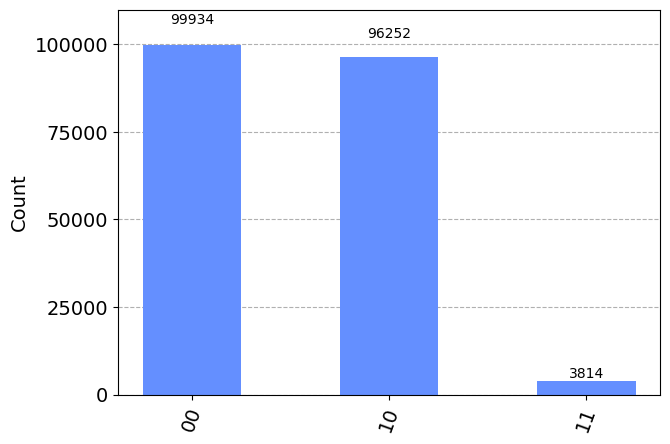

In [177]:
c_reg = QuantumRegister(1,name='q1')
color = QuantumRegister(1, name='q2')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
#qc.x(1)
#qc.barrier()
#qc.cry(0,color,c_reg)
#qc.barrier()
#qc.x(1)
qc.measure([0,1],[0,1])
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc, aer_sim)
qobj = assemble(t_qc_image, shots=200000)
job = aer_sim.run(qobj)
result = job.result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


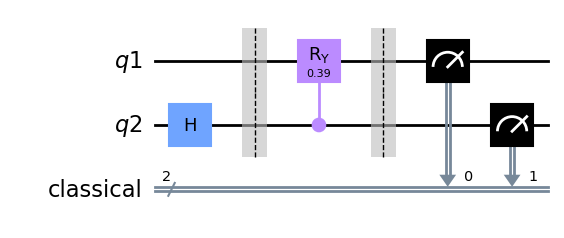

In [178]:
qc.draw('mpl')

C:\Users\HCI\AppData\Local\Temp\ipykernel_12944\549445223.py:18: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


{'00': 98321, '10': 99961, '01': 1718}


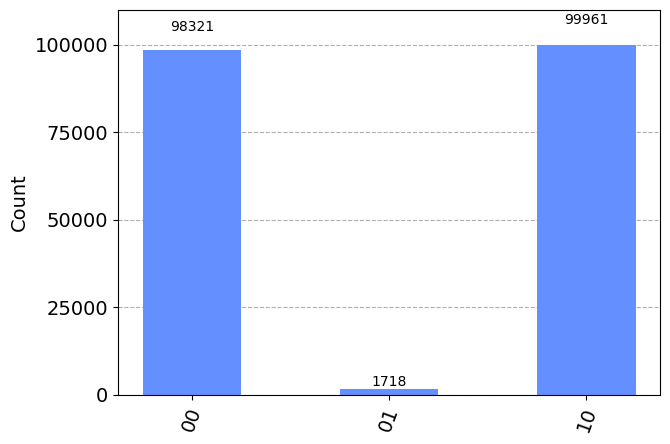

In [181]:
c_reg = QuantumRegister(1,name='q1')
color = QuantumRegister(1, name='q2')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
#qc.barrier()
#qc.cry(theta,color,c_reg)
#qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(0.262,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc, aer_sim)
qobj = assemble(t_qc_image, shots=200000)
job = aer_sim.run(qobj)
result = job.result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


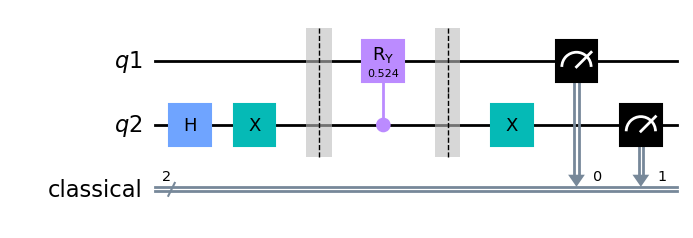

In [180]:
qc.draw('mpl')

In [182]:
c_reg = QuantumRegister(1,name='q1')
color = QuantumRegister(1, name='q2')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(0.262,color,c_reg)
qc.barrier()
qc.x(1)

In [184]:
theta

0.38998918982423

In [190]:
np.pi/4

0.7853981633974483

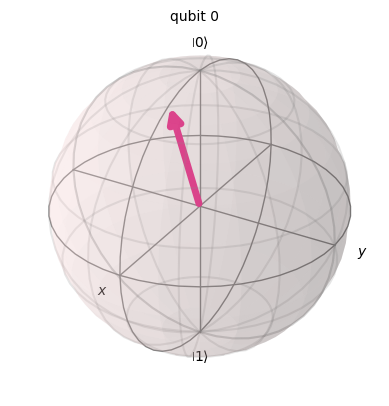

In [188]:
c_reg = QuantumRegister(1,name='q1')

classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg, classic)

qc.barrier()
qc.ry(np.pi/4,c_reg)
qc.barrier()

state = Statevector.from_instruction(qc)
plot_bloch_multivector(state)

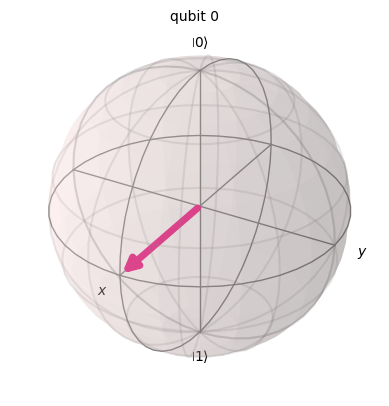

In [191]:
c_reg = QuantumRegister(1,name='q1')

classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg, classic)

qc.barrier()
qc.ry(np.pi/2,c_reg)
qc.barrier()

state = Statevector.from_instruction(qc)
plot_bloch_multivector(state)

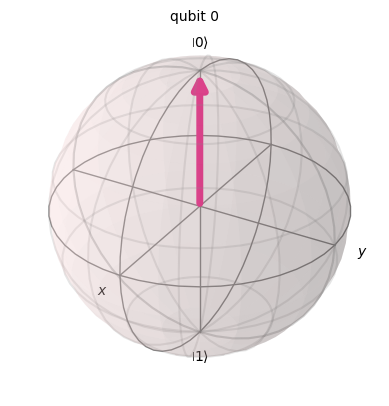

In [189]:
c_reg = QuantumRegister(1,name='q1')

classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg, classic)

qc.barrier()
qc.ry(0,c_reg)
qc.barrier()

state = Statevector.from_instruction(qc)
plot_bloch_multivector(state)

C:\Users\HCI\AppData\Local\Temp\ipykernel_12944\1829857421.py:5: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


{'10': 96156, '00': 98359, '11': 3819, '01': 1666}


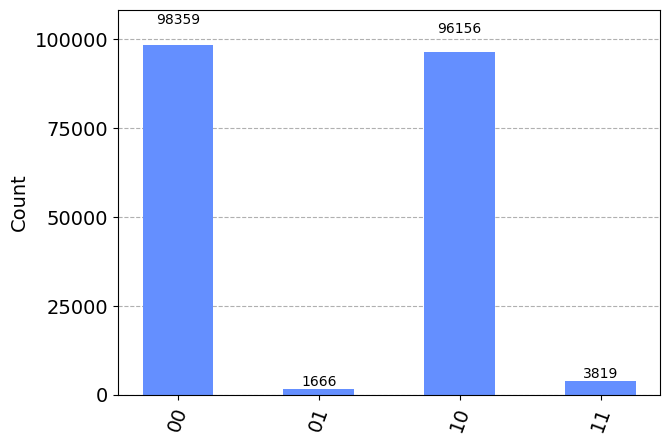

In [183]:
qc.measure([0,1],[0,1])
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc, aer_sim)
qobj = assemble(t_qc_image, shots=200000)
job = aer_sim.run(qobj)
result = job.result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)

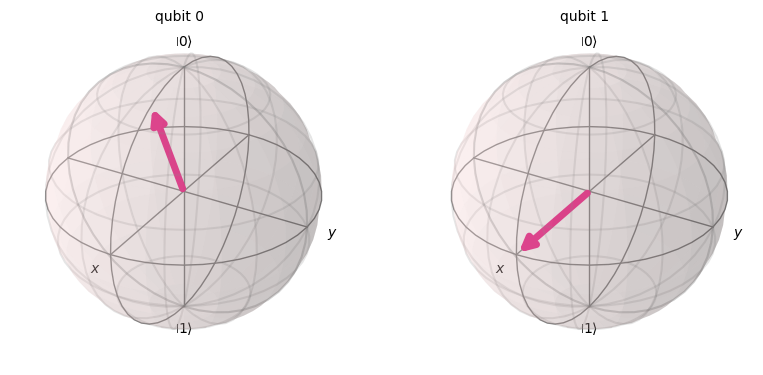

In [158]:
state = Statevector.from_instruction(qc)
plot_bloch_multivector(state)

In [172]:
c_reg = QuantumRegister(1,name='q1')
color = QuantumRegister(1, name='q2')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
#qc.cry(0.5236,color,c_reg)
qc.barrier()
qc.x(1)

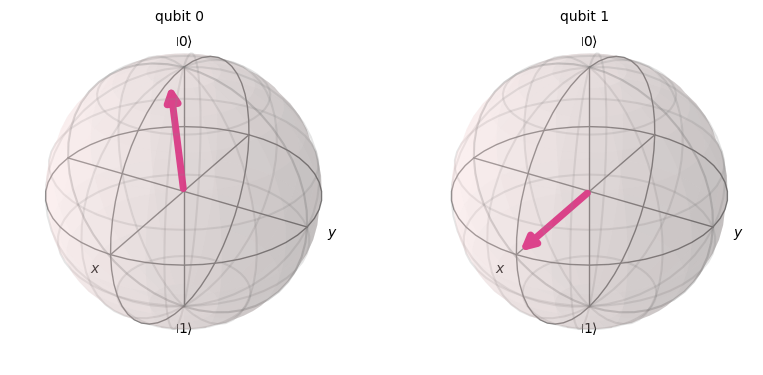

In [173]:
state = Statevector.from_instruction(qc)
plot_bloch_multivector(state)

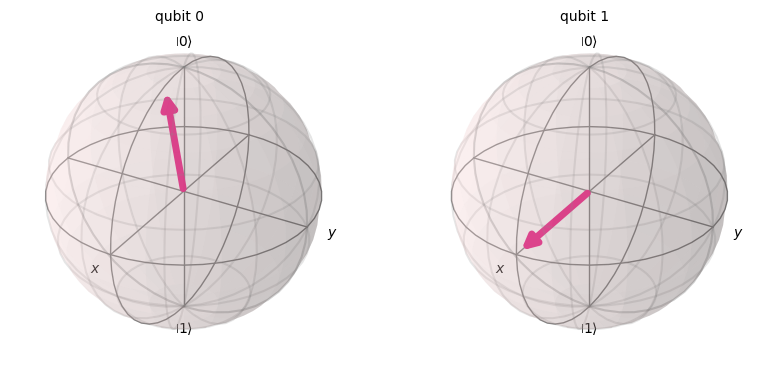

In [171]:
c_reg = QuantumRegister(1,name='q1')
color = QuantumRegister(1, name='q2')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
#qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(0.5236,color,c_reg)
qc.barrier()
qc.x(1)
state = Statevector.from_instruction(qc)
plot_bloch_multivector(state)

In [ ]:
qc.measure([0,1],[0,1])
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc, aer_sim)
qobj = assemble(t_qc_image, shots=200000)
job = aer_sim.run(qobj)
result = job.result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)

In [164]:
c_reg = QuantumRegister(1,name='q1')
color = QuantumRegister(1, name='q2')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(0.6160,color,c_reg, label='theta')
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(0.2618,color,c_reg, label = 'phi')
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


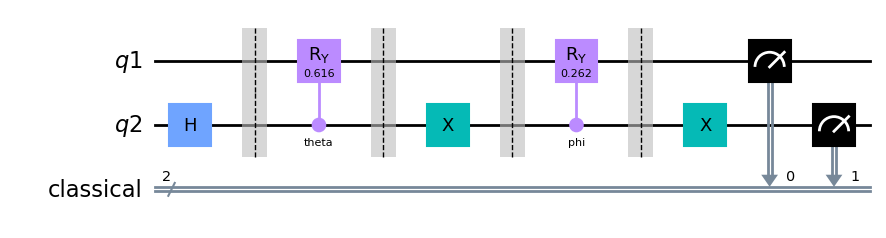

In [165]:
qc.draw('mpl')

In [144]:
from qiskit.circuit.library import mcry

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


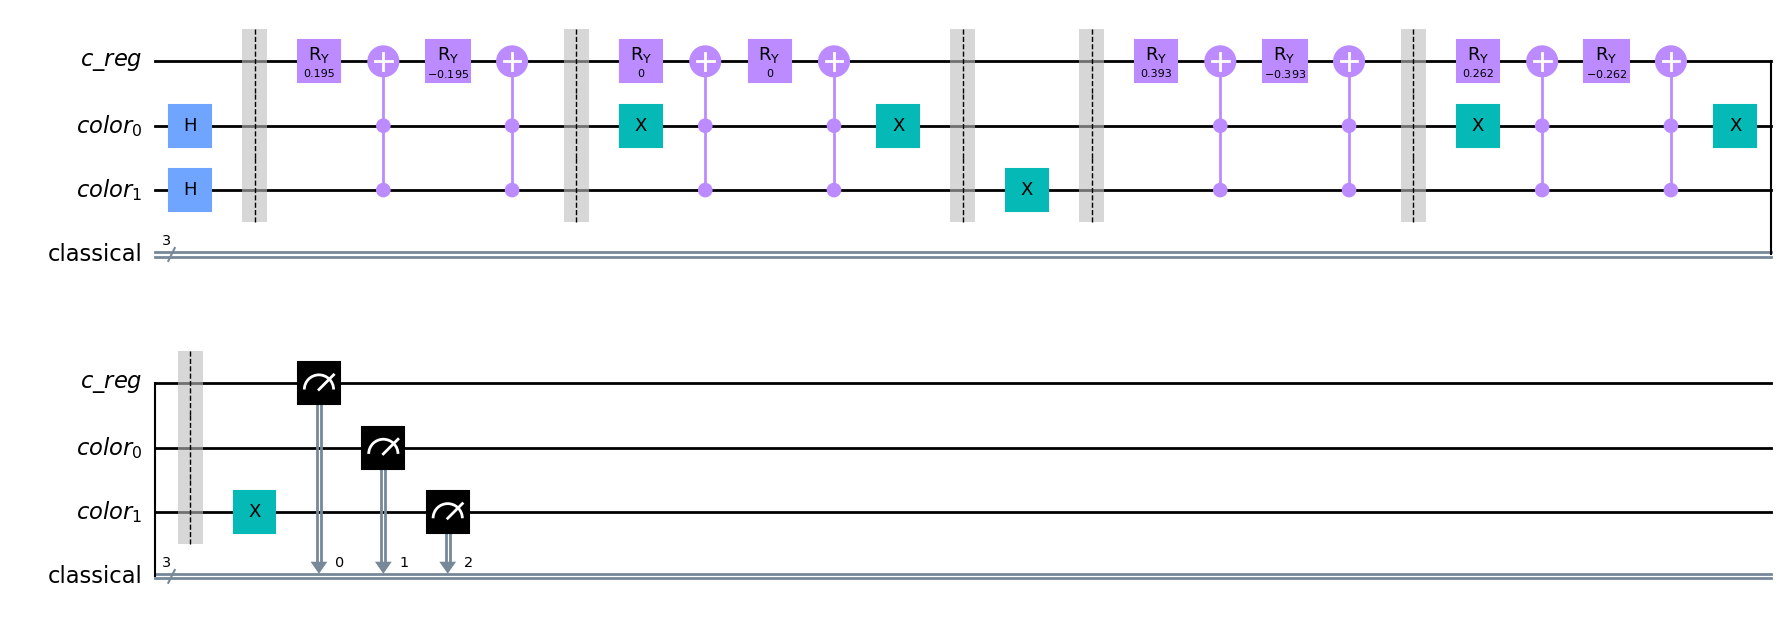

In [145]:
c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(2, name='color')
classic = ClassicalRegister(3, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.h(2)

qc.barrier()
qc.mcry(theta,color,c_reg)

qc.barrier()
qc.x(1)

qc.mcry(0,color,c_reg)

qc.x(1)
qc.barrier()

qc.x(2)
qc.barrier()
qc.mcry(0.785,color,c_reg)
qc.barrier()
qc.x(1)
qc.mcry(0.5236,color,c_reg)
qc.x(1)
qc.barrier()
qc.x(2)


qc.measure([0,1,2],[0,1,2])

qc.draw('mpl')

In [ ]:
c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(2, name='color')
classic = ClassicalRegister(3, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.h(2)

qc.barrier()
qc.mcry(theta,color,c_reg)

qc.barrier()
qc.x(1)

qc.mcry(0,color,c_reg)

qc.x(1)
qc.barrier()

qc.x(2)
qc.barrier()
qc.mcry(0.785,color,c_reg)
qc.barrier()
qc.x(1)
qc.mcry(0.5236,color,c_reg)
qc.x(1)
qc.barrier()
qc.x(2)


qc.measure([0,1,2],[0,1,2])

qc.draw('mpl') 

10.09360 s
[array([426.00562543,   0.        ,   0.        ])]


C:\Users\HCI\AppData\Local\Temp\ipykernel_12944\391213693.py:101: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1,1,c=colors_ionq, marker='o')


ValueError: 'c' argument has 3 elements, which is inconsistent with 'x' and 'y' with size 1.

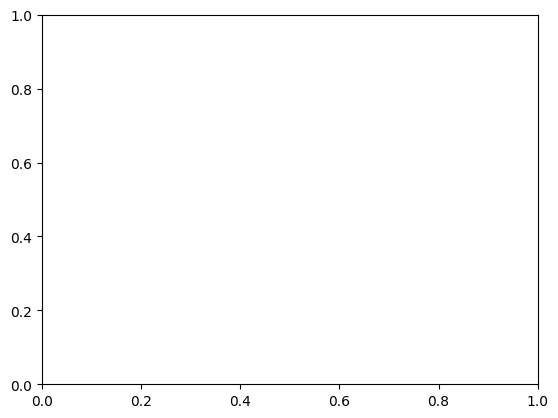

In [28]:
n = 255
k = 0

start_ionq = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [255,0,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta+0.5236,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

ionq_sim = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc, ionq_sim)
job_ionq = ionq_sim.run(t_qc_image, shots=200000)
result_ionq = job_ionq.result()
counts_ionq = result_ionq.get_counts()

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts_ionq.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(theta):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        theta = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color_ionq = []
for i in range(len(pixel_color_phi_recon)):
    n_recon_ionq = pixel_color_theta_recon[i] * 1020 / np.pi
    k_recon_ionq = pixel_color_phi_recon[i] * 6 * n_recon_ionq / np.pi
    recon_color_ionq.append(np.array([n_recon_ionq,k_recon_ionq,0]))
end_ionq = time.time()
time_ionq = end_ionq -  start_ionq
print(f'{time_ionq:.5f}', "s")
print(recon_color_ionq)
recon_color__ionq_index = recon_color_ionq[0]
fig = plt.figure()
ax = fig.add_subplot(111)
colors_ionq = recon_color__ionq_index / 255
ax.scatter(1,1,c=colors_ionq, marker='o')
ax.set_xlabel('Red')
ax.set_ylabel('Green')

In [32]:
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector

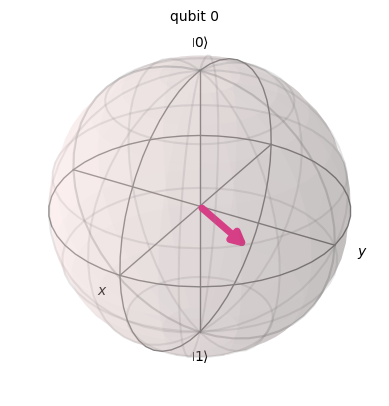

In [42]:
test = QuantumCircuit(1,1)
test.ry(np.pi/4,0)
test.y(0)
state = Statevector.from_instruction(test)
plot_bloch_multivector(state)

In [44]:
from qiskit_aer import AerSimulator

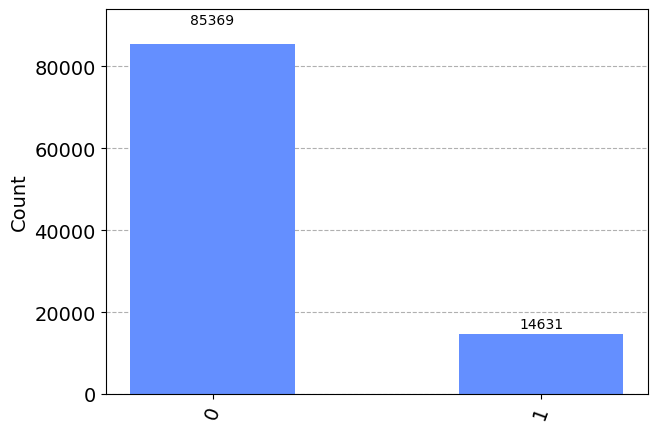

In [49]:
test = QuantumCircuit(1,1)
test.ry(np.pi/4,0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=100000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [51]:
2 *np.arccos(np.sqrt(85369/(100000)))

0.785011698958968

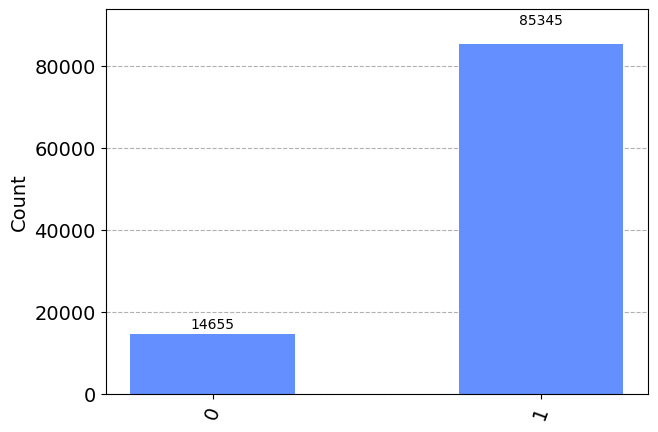

In [52]:
test = QuantumCircuit(1,1)
test.ry(np.pi/4,0)
test.y(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=100000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [53]:
2 *np.arccos(np.sqrt(14655/(100000)))

2.35590210017568

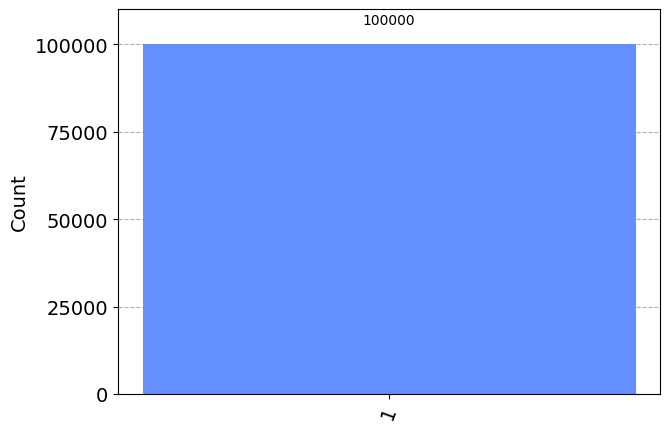

In [54]:
test = QuantumCircuit(1,1)

test.y(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=100000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

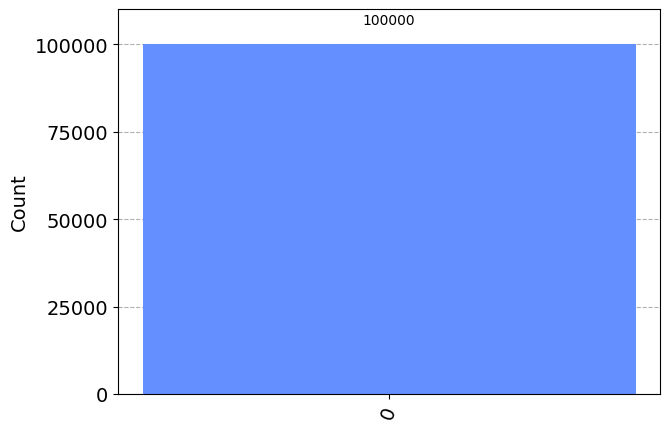

In [55]:
test = QuantumCircuit(1,1)
test.x(0)
test.y(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=100000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

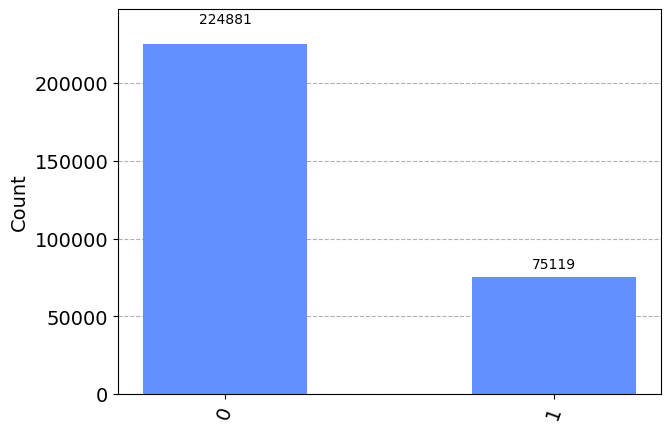

In [64]:
test = QuantumCircuit(1,1)
test.ry(np.pi/3,0)
test.z(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [65]:
2 *np.arccos(np.sqrt(224881/300000))

1.0481133716320996

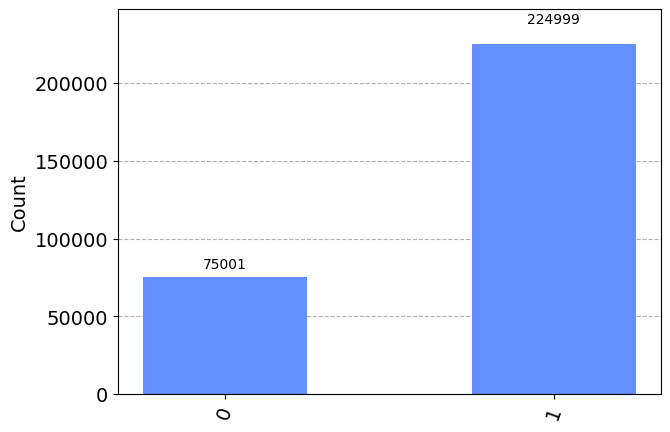

In [66]:
test = QuantumCircuit(1,1)
test.ry(2*np.pi/3,0)
test.z(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [67]:
2 *np.arccos(np.sqrt(75001/300000))

2.094387404406713

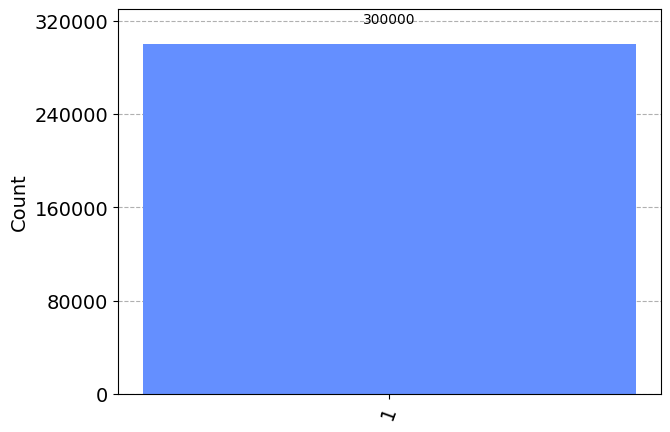

In [68]:
test = QuantumCircuit(1,1)
#test.ry(2*np.pi/3,0)
test.y(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [91]:
2 *np.arccos(np.sqrt(0/300000))

3.141592653589793

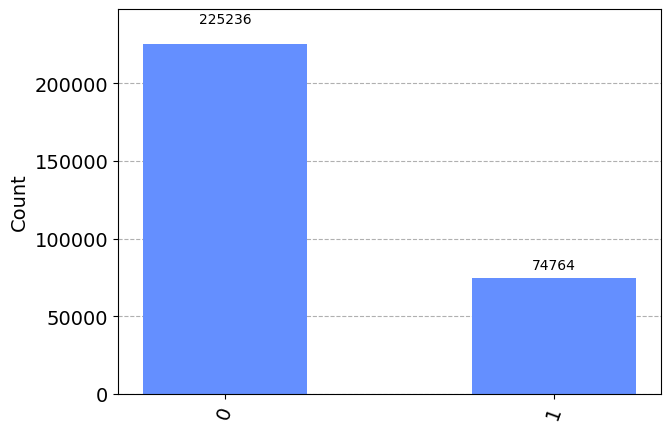

In [74]:
test = QuantumCircuit(1,1)
test.ry(np.pi/3,0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [85]:
2*np.arccos(np.sqrt(225236/300000))

1.0453798675738128

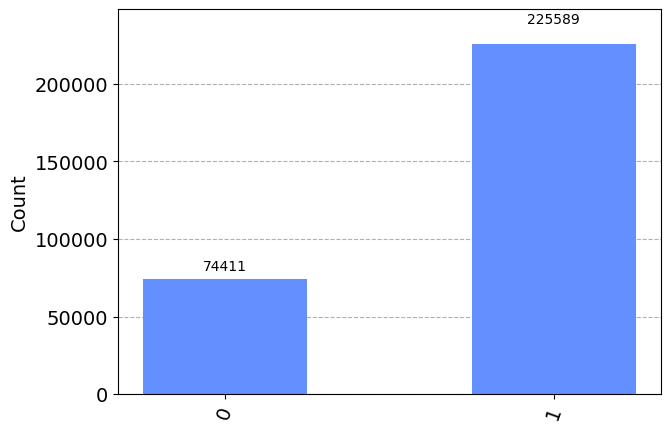

In [77]:
test = QuantumCircuit(1,1)
test.ry(np.pi/3,0)
test.y(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [86]:
2 *np.arccos(np.sqrt(74411/300000))

2.0989351923863264

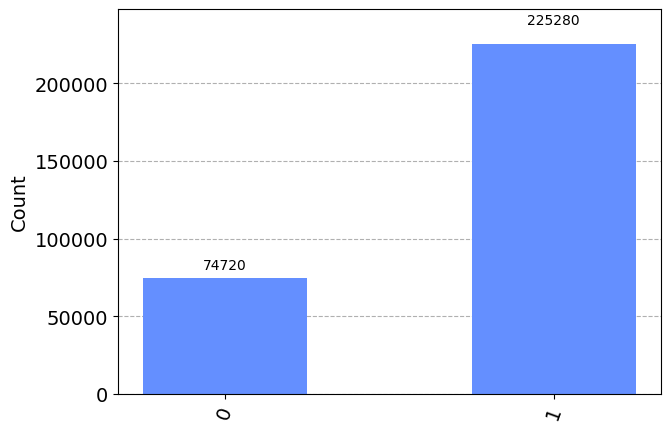

In [88]:
test = QuantumCircuit(1,1)
test.ry(2*np.pi/3,0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [87]:
2*np.arccos(np.sqrt(75012/300000))

2.094302728813224

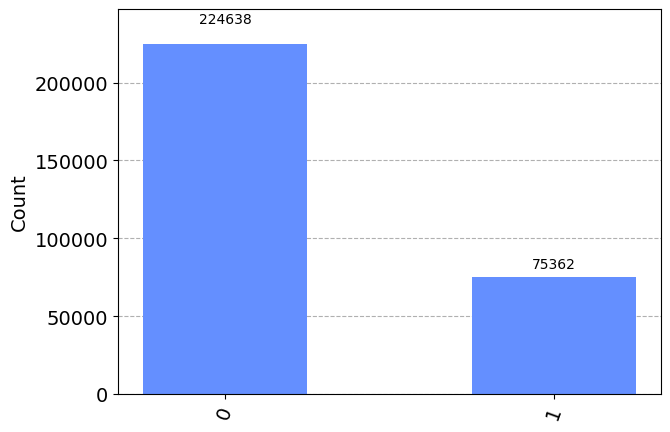

In [89]:
test = QuantumCircuit(1,1)
test.ry(2*np.pi/3,0)
test.y(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [90]:
2*np.arccos(np.sqrt(224947/300000))

1.0476054973568047

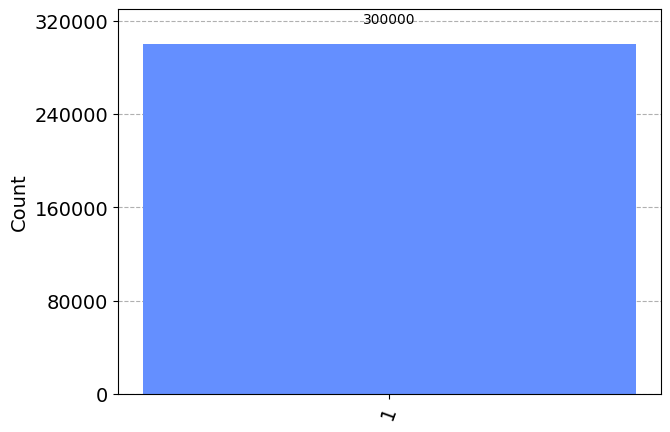

In [92]:
test = QuantumCircuit(1,1)
#test.ry(np.pi/3,0)
test.x(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [93]:
2*np.arccos(np.sqrt(0/300000))

3.141592653589793

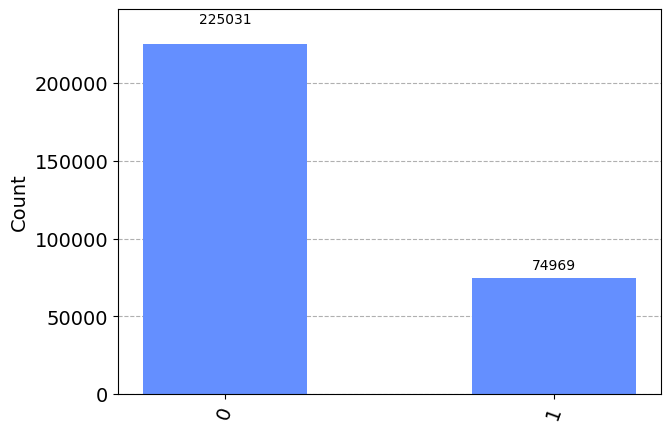

In [98]:
test = QuantumCircuit(1,1)
test.ry(np.pi/3,0)

test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [99]:
2*np.arccos(np.sqrt(225031/300000))

1.046958896641287

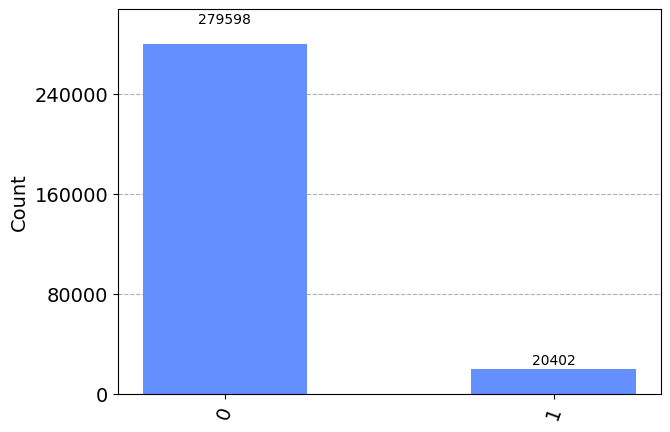

In [116]:
test = QuantumCircuit(1,1)
test.ry(0.5236,0)

test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [117]:
2*np.arccos(np.sqrt(279598/300000))

0.5276619633915896

In [118]:
2*np.arccos(np.sqrt(0/300000))

3.141592653589793

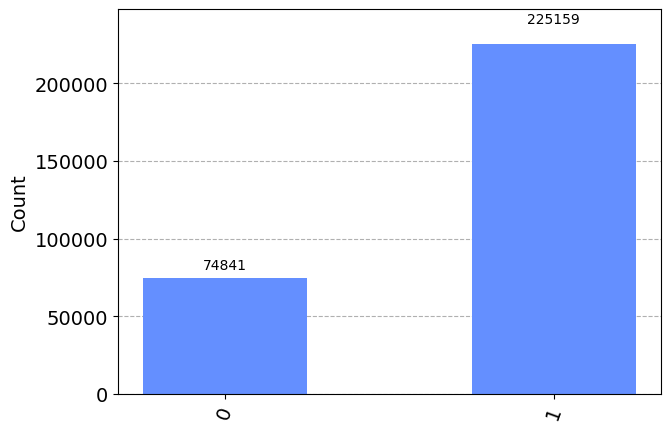

In [94]:
test = QuantumCircuit(1,1)
test.ry(np.pi/3,0)
test.x(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

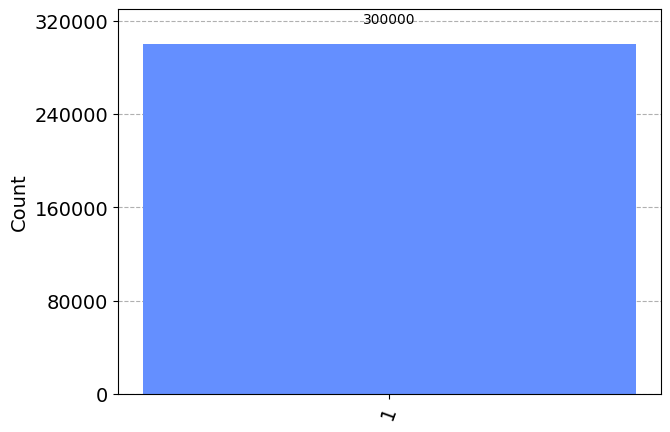

In [119]:
test = QuantumCircuit(1,1)
#test.ry(np.pi/3,0)
test.x(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

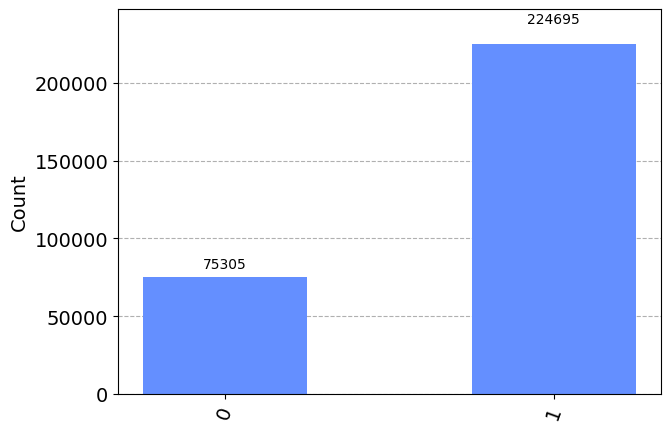

In [128]:
test = QuantumCircuit(1,1)
test.ry(2*np.pi/3,0)
#test.y(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [129]:
2*np.arccos(np.sqrt(75305/300000))

2.092048798342782

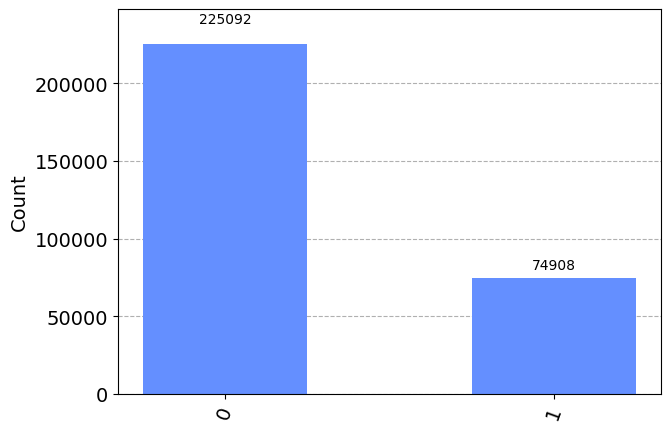

In [130]:
test = QuantumCircuit(1,1)
test.ry(2*np.pi/3,0)
test.y(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [127]:
2*np.arccos(np.sqrt(225325/300000))

1.0446938879044523

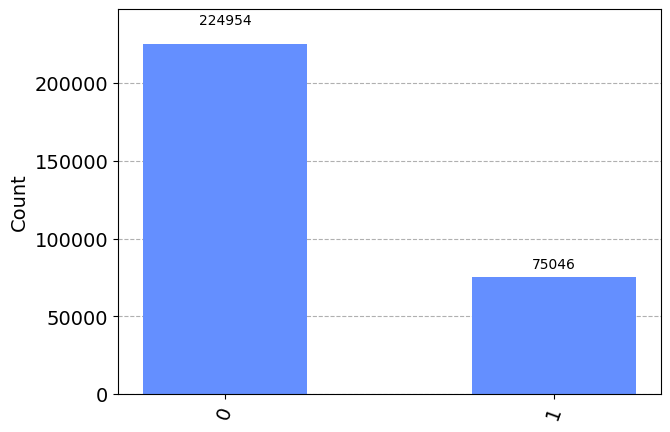

In [96]:
test = QuantumCircuit(1,1)
test.ry(2*np.pi/3,0)
test.x(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [97]:
2*np.arccos(np.sqrt(224954/300000))

1.0475516231787727

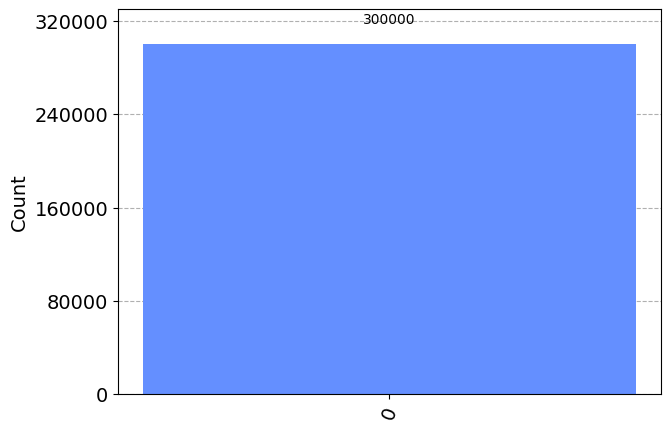

In [100]:
test = QuantumCircuit(1,1)
#test.ry(2*np.pi/3,0)
#test.x(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

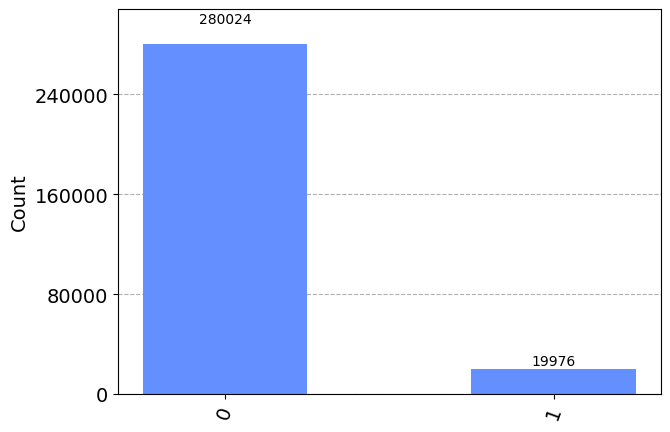

In [101]:
test = QuantumCircuit(1,1)
test.ry(0.5236,0)
#test.x(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [102]:
2*np.arccos(np.sqrt(280024/300000))

0.5219940189188228

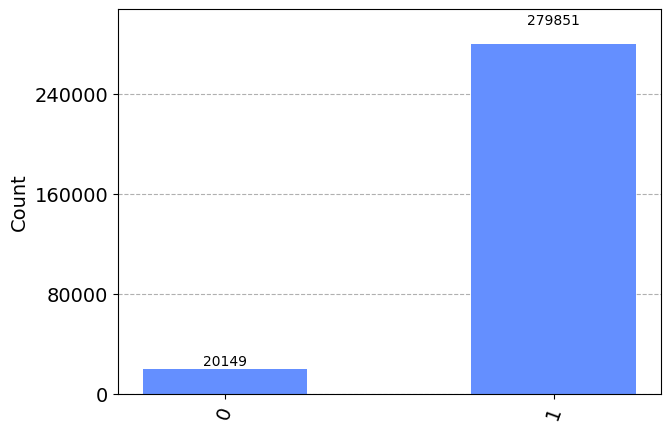

In [104]:
test = QuantumCircuit(1,1)
test.ry(0.5236,0)
test.y(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [105]:
2*np.arccos(np.sqrt(20149/300000))

2.6172901658962426

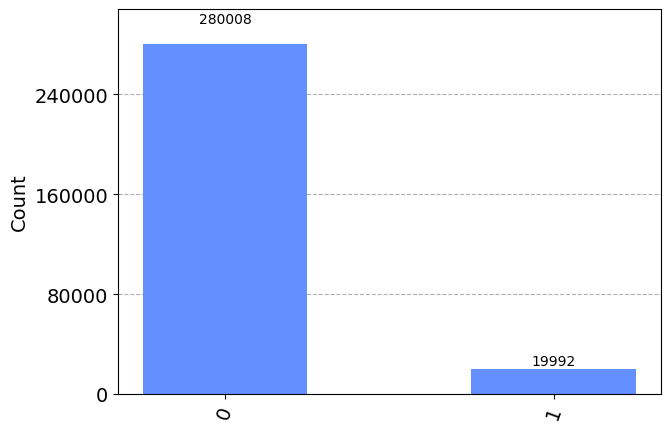

In [103]:
test = QuantumCircuit(1,1)
test.ry(np.pi/6,0)
#test.x(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [ ]:
5236

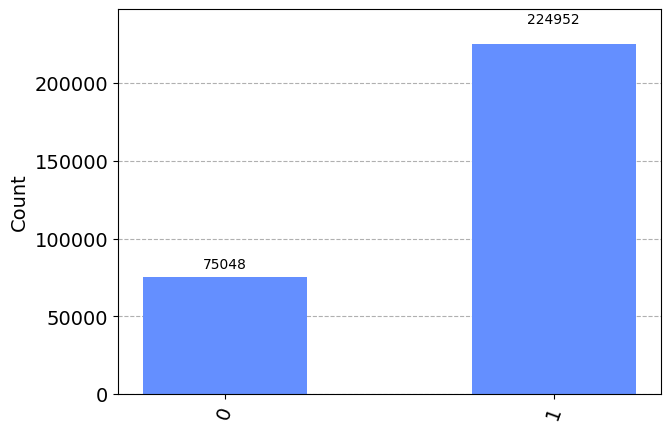

In [108]:
test = QuantumCircuit(1,1)
test.ry(2 * np.pi/3,0)
#test.x(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [109]:
2*np.arccos(np.sqrt(75048/300000))

2.0940256376178823

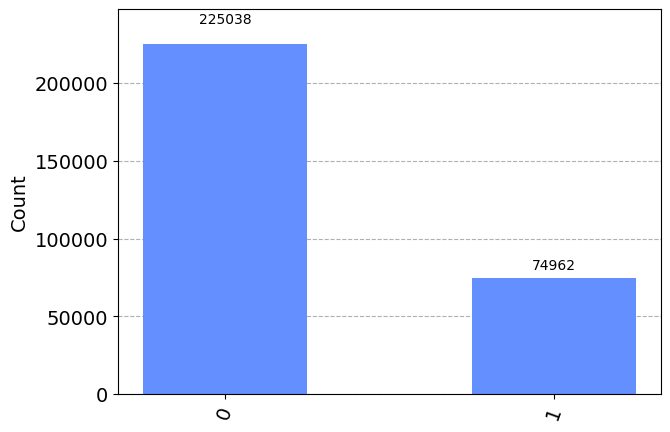

In [114]:
test = QuantumCircuit(1,1)
test.ry( np.pi/3,0)
#test.ry(2 *0.5236,0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [115]:
2*np.arccos(np.sqrt(225038/300000))

1.0469050023498236

In [37]:
test = QuantumCircuit(1,1)
test.ry(np.pi/4,0)
test.measure(0,0)
ionq_sim = provider.get_backend("ionq_simulator")
t_qc_image = transpile(test, ionq_sim)
job_ionq = ionq_sim.run(t_qc_image, shots=100000)
result_ionq = job_ionq.result()
plot_histogram(result_ionq)

AttributeError: Attribute values is not defined

In [38]:
test = QuantumCircuit(1,1)
test.ry(np.pi/4,0)
test.x(0)
test.measure(0,0)
ionq_sim = provider.get_backend("ionq_simulator")
t_qc_image = transpile(test, ionq_sim)
job_ionq = ionq_sim.run(t_qc_image, shots=100000)
result_ionq = job_ionq.result()
plot_histogram(result_ionq)

AttributeError: Attribute values is not defined

# Add rotation with Red color

7.97676 s
[array([253.01645215, 252.18052622,   0.        ])]


C:\Users\HCI\AppData\Local\Temp\ipykernel_12944\215263617.py:101: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1,1,c=colors_ionq, marker='o')


Text(0, 0.5, 'Green')

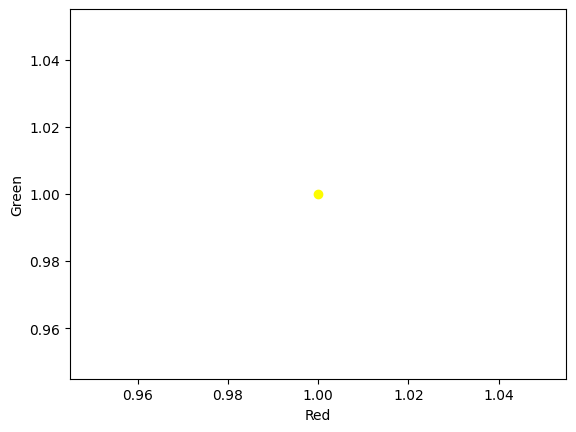

In [23]:
n = 255
k = 0

start_ionq = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [255,0,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi+0.5236,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

ionq_sim = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc, ionq_sim)
job_ionq = ionq_sim.run(t_qc_image, shots=200000)
result_ionq = job_ionq.result()
counts_ionq = result_ionq.get_counts()

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts_ionq.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(theta):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        theta = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color_ionq = []
for i in range(len(pixel_color_phi_recon)):
    n_recon_ionq = pixel_color_theta_recon[i] * 1020 / np.pi
    k_recon_ionq = pixel_color_phi_recon[i] * 6 * n_recon_ionq / np.pi
    recon_color_ionq.append(np.array([n_recon_ionq,k_recon_ionq,0]))
end_ionq = time.time()
time_ionq = end_ionq -  start_ionq
print(f'{time_ionq:.5f}', "s")
print(recon_color_ionq)
recon_color__ionq_index = recon_color_ionq[0]
fig = plt.figure()
ax = fig.add_subplot(111)
colors_ionq = recon_color__ionq_index / 255
ax.scatter(1,1,c=colors_ionq, marker='o')
ax.set_xlabel('Red')
ax.set_ylabel('Green')

20.04725 s
[array([254.25618857, 506.80545368,   0.        ])]


C:\Users\HCI\AppData\Local\Temp\ipykernel_12944\4207986052.py:101: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1,1,c=colors_ionq, marker='o')


ValueError: 'c' argument has 3 elements, which is inconsistent with 'x' and 'y' with size 1.

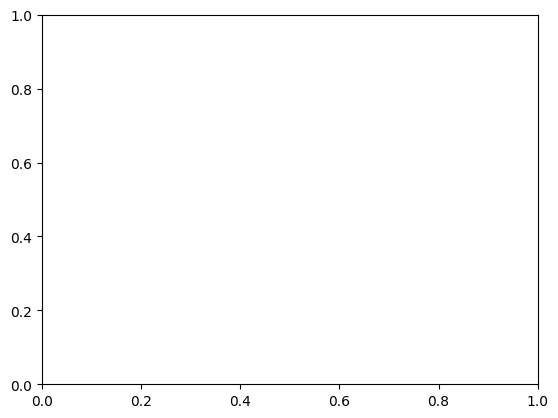

In [24]:
n = 255
k = 0

start_ionq = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [255,0,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi+0.5236*2,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

ionq_sim = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc, ionq_sim)
job_ionq = ionq_sim.run(t_qc_image, shots=200000)
result_ionq = job_ionq.result()
counts_ionq = result_ionq.get_counts()

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts_ionq.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(theta):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        theta = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color_ionq = []
for i in range(len(pixel_color_phi_recon)):
    n_recon_ionq = pixel_color_theta_recon[i] * 1020 / np.pi
    k_recon_ionq = pixel_color_phi_recon[i] * 6 * n_recon_ionq / np.pi
    recon_color_ionq.append(np.array([n_recon_ionq,k_recon_ionq,0]))
end_ionq = time.time()
time_ionq = end_ionq -  start_ionq
print(f'{time_ionq:.5f}', "s")
print(recon_color_ionq)
recon_color__ionq_index = recon_color_ionq[0]
fig = plt.figure()
ax = fig.add_subplot(111)
colors_ionq = recon_color__ionq_index / 255
ax.scatter(1,1,c=colors_ionq, marker='o')
ax.set_xlabel('Red')
ax.set_ylabel('Green')

8.42509 s
[array([765.19447247,   0.        ,   0.        ])]


C:\Users\HCI\AppData\Local\Temp\ipykernel_12944\686404906.py:102: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1,1,c=colors_ionq, marker='o')


ValueError: 'c' argument has 3 elements, which is inconsistent with 'x' and 'y' with size 1.

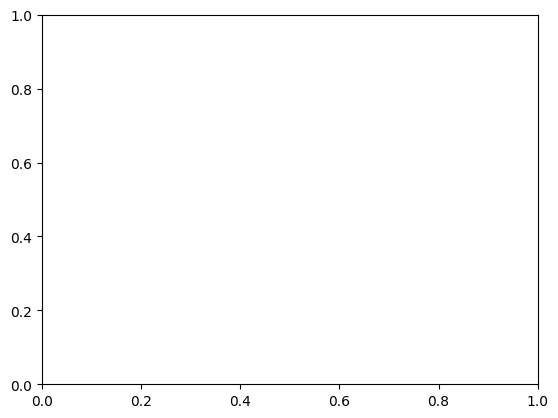

In [25]:
n = 255
k = 0

start_ionq = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [255,0,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi,color,c_reg)
qc.x(c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

ionq_sim = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc, ionq_sim)
job_ionq = ionq_sim.run(t_qc_image, shots=200000)
result_ionq = job_ionq.result()
counts_ionq = result_ionq.get_counts()

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts_ionq.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(theta):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        theta = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color_ionq = []
for i in range(len(pixel_color_phi_recon)):
    n_recon_ionq = pixel_color_theta_recon[i] * 1020 / np.pi
    k_recon_ionq = pixel_color_phi_recon[i] * 6 * n_recon_ionq / np.pi
    recon_color_ionq.append(np.array([n_recon_ionq,k_recon_ionq,0]))
end_ionq = time.time()
time_ionq = end_ionq -  start_ionq
print(f'{time_ionq:.5f}', "s")
print(recon_color_ionq)
recon_color__ionq_index = recon_color_ionq[0]
fig = plt.figure()
ax = fig.add_subplot(111)
colors_ionq = recon_color__ionq_index / 255
ax.scatter(1,1,c=colors_ionq, marker='o')
ax.set_xlabel('Red')
ax.set_ylabel('Green')

In [13]:
n = 200
k = 100

start_ionq = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [200,100,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

ionq_sim = provider.get_backend("ionq_qpu.aria-1")
t_qc_image = transpile(qc, ionq_sim)
job_ionq = ionq_sim.run(t_qc_image, shots=10000)
result_ionq = job_ionq.result()
counts_ionq = result_ionq.get_counts()

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts_ionq.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(theta):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        theta = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color_ionq = []
for i in range(len(pixel_color_phi_recon)):
    n_recon_ionq = pixel_color_theta_recon[i] * 1020 / np.pi
    k_recon_ionq = pixel_color_phi_recon[i] * 6 * n_recon_ionq / np.pi
    recon_color_ionq.append(np.array([n_recon_ionq,k_recon_ionq,0]))
end_ionq = time.time()
time_ionq = end_ionq -  start_ionq
print(f'{time_ionq:.5f}', "s")
print(recon_color_ionq)
recon_color__ionq_index = recon_color_ionq[0]
fig = plt.figure()
ax = fig.add_subplot(111)
colors_ionq = recon_color__ionq_index / 255
ax.scatter(1,1,c=colors_ionq, marker='o')
ax.set_xlabel('Red')
ax.set_ylabel('Green')

IonQJobStateError: IonQJobStateError('Unable to retreive result for job e299f8d3-3beb-4b02-a425-4b2e6eb96982. Job was cancelled"')

In [16]:
result_ionq = job_ionq.result()

IonQAPIError: IonQAPIError(message='No error details provided.',status_code=530,headers={'Date': 'Sun, 21 Jul 2024 07:29:03 GMT', 'Content-Type': 'text/html; charset=UTF-8', 'Content-Length': '6168', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '8a697a4c3c6df695-NRT'},body=<!DOCTYPE html>
<!--[if lt IE 7]> <html class="no-js ie6 oldie" lang="en-US"> <![endif]-->
<!--[if IE 7]>    <html class="no-js ie7 oldie" lang="en-US"> <![endif]-->
<!--[if IE 8]>    <html class="no-js ie8 oldie" lang="en-US"> <![endif]-->
<!--[if gt IE 8]><!--> <html class="no-js" lang="en-US"> <!--<![endif]-->
<head>
<title>Argo Tunnel error | api.ionq.co | Cloudflare</title>
<meta charset="UTF-8" />
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />
<meta http-equiv="X-UA-Compatible" content="IE=Edge" />
<meta name="robots" content="noindex, nofollow" />
<meta name="viewport" content="width=device-width,initial-scale=1" />
<link rel="stylesheet" id="cf_styles-css" href="/cdn-cgi/styles/main.css" />


<script>
(function(){if(document.addEventListener&&window.XMLHttpRequest&&JSON&&JSON.stringify){var e=function(a){var c=document.getElementById("error-feedback-survey"),d=document.getElementById("error-feedback-success"),b=new XMLHttpRequest;a={event:"feedback clicked",properties:{errorCode:1033,helpful:a,version:1}};b.open("POST","https://sparrow.cloudflare.com/api/v1/event");b.setRequestHeader("Content-Type","application/json");b.setRequestHeader("Sparrow-Source-Key","c771f0e4b54944bebf4261d44bd79a1e");
b.send(JSON.stringify(a));c.classList.add("feedback-hidden");d.classList.remove("feedback-hidden")};document.addEventListener("DOMContentLoaded",function(){var a=document.getElementById("error-feedback"),c=document.getElementById("feedback-button-yes"),d=document.getElementById("feedback-button-no");"classList"in a&&(a.classList.remove("feedback-hidden"),c.addEventListener("click",function(){e(!0)}),d.addEventListener("click",function(){e(!1)}))})}})();
</script>

<script defer src="https://performance.radar.cloudflare.com/beacon.js"></script>
</head>
<body>
  <div id="cf-wrapper">
    <div class="cf-alert cf-alert-error cf-cookie-error hidden" id="cookie-alert" data-translate="enable_cookies">Please enable cookies.</div>
    <div id="cf-error-details" class="p-0">
      <header class="mx-auto pt-10 lg:pt-6 lg:px-8 w-240 lg:w-full mb-15 antialiased">
         <h1 class="inline-block md:block mr-2 md:mb-2 font-light text-60 md:text-3xl text-black-dark leading-tight">
           <span data-translate="error">Error</span>
           <span>1033</span>
         </h1>
         <span class="inline-block md:block heading-ray-id font-mono text-15 lg:text-sm lg:leading-relaxed">Ray ID: 8a697a4c3c6df695 &bull;</span>
         <span class="inline-block md:block heading-ray-id font-mono text-15 lg:text-sm lg:leading-relaxed">2024-07-21 07:29:03 UTC</span>
        <h2 class="text-gray-600 leading-1.3 text-3xl lg:text-2xl font-light">Argo Tunnel error</h2>
      </header>

      <section class="w-240 lg:w-full mx-auto mb-8 lg:px-8">
          <div id="what-happened-section" class="w-1/2 md:w-full">
            <h2 class="text-3xl leading-tight font-normal mb-4 text-black-dark antialiased" data-translate="what_happened">What happened?</h2>
            <p>You've requested a page on a website (api.ionq.co) that is on the <a href="https://www.cloudflare.com/5xx-error-landing/" target="_blank">Cloudflare</a> network. The host (api.ionq.co) is configured as an Argo Tunnel, and Cloudflare is currently unable to resolve it.
            
          </div>

          
          <div id="resolution-copy-section" class="w-1/2 mt-6 text-15 leading-normal">
            <h2 class="text-3xl leading-tight font-normal mb-4 text-black-dark antialiased" data-translate="what_can_i_do">What can I do?</h2>
            <p><strong>If you are a visitor of this website:</strong><br />Please try again in a few minutes.</p><p><strong>If you are the owner of this website:</strong><br />Ensure that cloudflared is running and can reach the network. You may wish to enable <a rel="noopener noreferrer" href="https://developers.cloudflare.com/argo-tunnel/reference/load-balancing/">load balancing</a> for your tunnel.</p>
          </div>
          
      </section>

      <div class="feedback-hidden py-8 text-center" id="error-feedback">
    <div id="error-feedback-survey" class="footer-line-wrapper">
        Was this page helpful?
        <button class="border border-solid bg-white cf-button cursor-pointer ml-4 px-4 py-2 rounded" id="feedback-button-yes" type="button">Yes</button>
        <button class="border border-solid bg-white cf-button cursor-pointer ml-4 px-4 py-2 rounded" id="feedback-button-no" type="button">No</button>
    </div>
    <div class="feedback-success feedback-hidden" id="error-feedback-success">
        Thank you for your feedback!
    </div>
</div>


      <div class="cf-error-footer cf-wrapper w-240 lg:w-full py-10 sm:py-4 sm:px-8 mx-auto text-center sm:text-left border-solid border-0 border-t border-gray-300">
  <p class="text-13">
    <span class="cf-footer-item sm:block sm:mb-1">Cloudflare Ray ID: <strong class="font-semibold">8a697a4c3c6df695</strong></span>
    <span class="cf-footer-separator sm:hidden">&bull;</span>
    <span id="cf-footer-item-ip" class="cf-footer-item hidden sm:block sm:mb-1">
      Your IP:
      <button type="button" id="cf-footer-ip-reveal" class="cf-footer-ip-reveal-btn">Click to reveal</button>
      <span class="hidden" id="cf-footer-ip">203.246.113.85</span>
      <span class="cf-footer-separator sm:hidden">&bull;</span>
    </span>
    <span class="cf-footer-item sm:block sm:mb-1"><span>Performance &amp; security by</span> <a rel="noopener noreferrer" href="https://www.cloudflare.com/5xx-error-landing" id="brand_link" target="_blank">Cloudflare</a></span>
    
  </p>
  <script>(function(){function d(){var b=a.getElementById("cf-footer-item-ip"),c=a.getElementById("cf-footer-ip-reveal");b&&"classList"in b&&(b.classList.remove("hidden"),c.addEventListener("click",function(){c.classList.add("hidden");a.getElementById("cf-footer-ip").classList.remove("hidden")}))}var a=document;document.addEventListener&&a.addEventListener("DOMContentLoaded",d)})();</script>
</div><!-- /.error-footer -->


    </div><!-- /#cf-error-details -->
  </div><!-- /#cf-wrapper -->

  <script>
  window._cf_translation = {};
  
  
</script>

</body>
</html>
,error_type='internal_error')

In [ ]:

counts_ionq = result_ionq.get_counts()

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts_ionq.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(theta):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        theta = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color_ionq = []
for i in range(len(pixel_color_phi_recon)):
    n_recon_ionq = pixel_color_theta_recon[i] * 1020 / np.pi
    k_recon_ionq = pixel_color_phi_recon[i] * 6 * n_recon_ionq / np.pi
    recon_color_ionq.append(np.array([n_recon_ionq,k_recon_ionq,0]))
end_ionq = time.time()
time_ionq = end_ionq -  start_ionq
print(f'{time_ionq:.5f}', "s")
print(recon_color_ionq)
recon_color__ionq_index = recon_color_ionq[0]
fig = plt.figure()
ax = fig.add_subplot(111)
colors_ionq = recon_color__ionq_index / 255
ax.scatter(1,1,c=colors_ionq, marker='o')
ax.set_xlabel('Red')
ax.set_ylabel('Green')

In [59]:
error_ionq = []
for i in range(1):
    del_x = recon_color_ionq[0][0] - n
    del_y = recon_color_ionq[0][1] - k
    err_ionq = np.sqrt(del_x**2+del_y**2)
    error_ionq.append(err_ionq)

print("error = ",error_ionq,"time = ", time_ionq)

error =  [24.677950587085036] time =  374.0126967430115


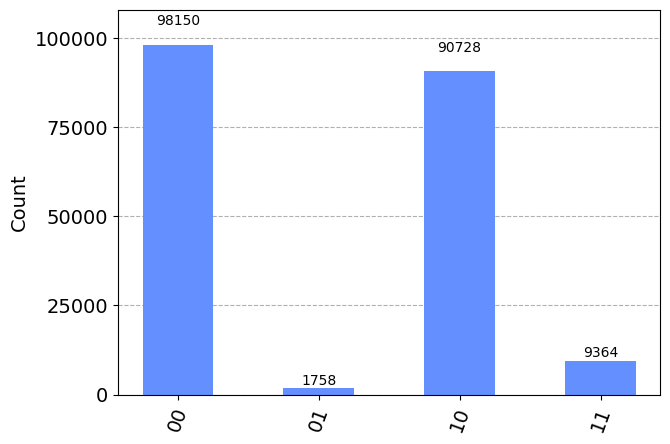

In [54]:
plot_histogram(counts)

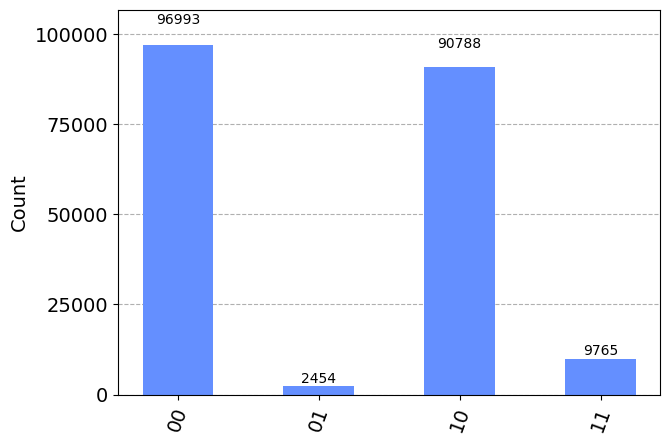

In [56]:
plot_histogram(counts_ionq)

# Aria-1

In [15]:
n = 200
k = 100

start_ionq = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

ionq_sim = provider.get_backend("ionq_qpu.aria-1")
t_qc_image = transpile(qc, ionq_sim)
job_ionq = ionq_sim.run(t_qc_image, shots=30000)
result_ionq = job_ionq.result()
counts_ionq = result_ionq.get_counts()

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts_ionq.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(theta):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        theta = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color_ionq = []
for i in range(len(pixel_color_phi_recon)):
    n_recon_ionq = pixel_color_theta_recon[i] * 1020 / np.pi
    k_recon_ionq = pixel_color_phi_recon[i] * 6 * n_recon_ionq / np.pi
    recon_color_ionq.append(np.array([n_recon_ionq,k_recon_ionq,0]))
end_ionq = time.time()
time_ionq = end_ionq -  start_ionq
print(f'{time_ionq:.5f}', "s")
print(recon_color_ionq)
recon_color__ionq_index = recon_color_ionq[0]
fig = plt.figure()
ax = fig.add_subplot(111)
colors_ionq = recon_color__ionq_index / 255
ax.scatter(1,1,c=colors_ionq, marker='o')
ax.set_xlabel('Red')
ax.set_ylabel('Green')

IonQAPIError: IonQAPIError(message='No error details provided.',status_code=530,headers={'Date': 'Tue, 16 Jul 2024 06:11:15 GMT', 'Content-Type': 'text/html; charset=UTF-8', 'Content-Length': '6168', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '8a3fd5762afff57f-NRT'},body=<!DOCTYPE html>
<!--[if lt IE 7]> <html class="no-js ie6 oldie" lang="en-US"> <![endif]-->
<!--[if IE 7]>    <html class="no-js ie7 oldie" lang="en-US"> <![endif]-->
<!--[if IE 8]>    <html class="no-js ie8 oldie" lang="en-US"> <![endif]-->
<!--[if gt IE 8]><!--> <html class="no-js" lang="en-US"> <!--<![endif]-->
<head>
<title>Argo Tunnel error | api.ionq.co | Cloudflare</title>
<meta charset="UTF-8" />
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />
<meta http-equiv="X-UA-Compatible" content="IE=Edge" />
<meta name="robots" content="noindex, nofollow" />
<meta name="viewport" content="width=device-width,initial-scale=1" />
<link rel="stylesheet" id="cf_styles-css" href="/cdn-cgi/styles/main.css" />


<script>
(function(){if(document.addEventListener&&window.XMLHttpRequest&&JSON&&JSON.stringify){var e=function(a){var c=document.getElementById("error-feedback-survey"),d=document.getElementById("error-feedback-success"),b=new XMLHttpRequest;a={event:"feedback clicked",properties:{errorCode:1033,helpful:a,version:1}};b.open("POST","https://sparrow.cloudflare.com/api/v1/event");b.setRequestHeader("Content-Type","application/json");b.setRequestHeader("Sparrow-Source-Key","c771f0e4b54944bebf4261d44bd79a1e");
b.send(JSON.stringify(a));c.classList.add("feedback-hidden");d.classList.remove("feedback-hidden")};document.addEventListener("DOMContentLoaded",function(){var a=document.getElementById("error-feedback"),c=document.getElementById("feedback-button-yes"),d=document.getElementById("feedback-button-no");"classList"in a&&(a.classList.remove("feedback-hidden"),c.addEventListener("click",function(){e(!0)}),d.addEventListener("click",function(){e(!1)}))})}})();
</script>

<script defer src="https://performance.radar.cloudflare.com/beacon.js"></script>
</head>
<body>
  <div id="cf-wrapper">
    <div class="cf-alert cf-alert-error cf-cookie-error hidden" id="cookie-alert" data-translate="enable_cookies">Please enable cookies.</div>
    <div id="cf-error-details" class="p-0">
      <header class="mx-auto pt-10 lg:pt-6 lg:px-8 w-240 lg:w-full mb-15 antialiased">
         <h1 class="inline-block md:block mr-2 md:mb-2 font-light text-60 md:text-3xl text-black-dark leading-tight">
           <span data-translate="error">Error</span>
           <span>1033</span>
         </h1>
         <span class="inline-block md:block heading-ray-id font-mono text-15 lg:text-sm lg:leading-relaxed">Ray ID: 8a3fd5762afff57f &bull;</span>
         <span class="inline-block md:block heading-ray-id font-mono text-15 lg:text-sm lg:leading-relaxed">2024-07-16 06:11:15 UTC</span>
        <h2 class="text-gray-600 leading-1.3 text-3xl lg:text-2xl font-light">Argo Tunnel error</h2>
      </header>

      <section class="w-240 lg:w-full mx-auto mb-8 lg:px-8">
          <div id="what-happened-section" class="w-1/2 md:w-full">
            <h2 class="text-3xl leading-tight font-normal mb-4 text-black-dark antialiased" data-translate="what_happened">What happened?</h2>
            <p>You've requested a page on a website (api.ionq.co) that is on the <a href="https://www.cloudflare.com/5xx-error-landing/" target="_blank">Cloudflare</a> network. The host (api.ionq.co) is configured as an Argo Tunnel, and Cloudflare is currently unable to resolve it.
            
          </div>

          
          <div id="resolution-copy-section" class="w-1/2 mt-6 text-15 leading-normal">
            <h2 class="text-3xl leading-tight font-normal mb-4 text-black-dark antialiased" data-translate="what_can_i_do">What can I do?</h2>
            <p><strong>If you are a visitor of this website:</strong><br />Please try again in a few minutes.</p><p><strong>If you are the owner of this website:</strong><br />Ensure that cloudflared is running and can reach the network. You may wish to enable <a rel="noopener noreferrer" href="https://developers.cloudflare.com/argo-tunnel/reference/load-balancing/">load balancing</a> for your tunnel.</p>
          </div>
          
      </section>

      <div class="feedback-hidden py-8 text-center" id="error-feedback">
    <div id="error-feedback-survey" class="footer-line-wrapper">
        Was this page helpful?
        <button class="border border-solid bg-white cf-button cursor-pointer ml-4 px-4 py-2 rounded" id="feedback-button-yes" type="button">Yes</button>
        <button class="border border-solid bg-white cf-button cursor-pointer ml-4 px-4 py-2 rounded" id="feedback-button-no" type="button">No</button>
    </div>
    <div class="feedback-success feedback-hidden" id="error-feedback-success">
        Thank you for your feedback!
    </div>
</div>


      <div class="cf-error-footer cf-wrapper w-240 lg:w-full py-10 sm:py-4 sm:px-8 mx-auto text-center sm:text-left border-solid border-0 border-t border-gray-300">
  <p class="text-13">
    <span class="cf-footer-item sm:block sm:mb-1">Cloudflare Ray ID: <strong class="font-semibold">8a3fd5762afff57f</strong></span>
    <span class="cf-footer-separator sm:hidden">&bull;</span>
    <span id="cf-footer-item-ip" class="cf-footer-item hidden sm:block sm:mb-1">
      Your IP:
      <button type="button" id="cf-footer-ip-reveal" class="cf-footer-ip-reveal-btn">Click to reveal</button>
      <span class="hidden" id="cf-footer-ip">203.246.113.85</span>
      <span class="cf-footer-separator sm:hidden">&bull;</span>
    </span>
    <span class="cf-footer-item sm:block sm:mb-1"><span>Performance &amp; security by</span> <a rel="noopener noreferrer" href="https://www.cloudflare.com/5xx-error-landing" id="brand_link" target="_blank">Cloudflare</a></span>
    
  </p>
  <script>(function(){function d(){var b=a.getElementById("cf-footer-item-ip"),c=a.getElementById("cf-footer-ip-reveal");b&&"classList"in b&&(b.classList.remove("hidden"),c.addEventListener("click",function(){c.classList.add("hidden");a.getElementById("cf-footer-ip").classList.remove("hidden")}))}var a=document;document.addEventListener&&a.addEventListener("DOMContentLoaded",d)})();</script>
</div><!-- /.error-footer -->


    </div><!-- /#cf-error-details -->
  </div><!-- /#cf-wrapper -->

  <script>
  window._cf_translation = {};
  
  
</script>

</body>
</html>
,error_type='internal_error')

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


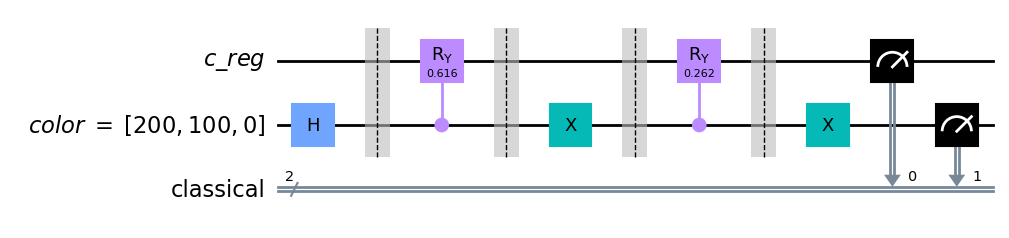

In [57]:
qc.draw('mpl')

In [20]:
color_angle_np = np.array([point[0] for point in color_angle])

# Find unique rows
_, unique_indices = np.unique(color_index_np, axis=0, return_index=True)
color_angle_unique = color_angle_np[unique_indices]

unique_color_list = color_list_unique.tolist()
unique_color_index = color_index_unique.tolist()
unique_color_angle = color_angle_unique.tolist()

In [5]:
for i in range(32):
    color_space = pd.Series(unique_color_list[524288*i:524288*(i+1)], index = pd.Index(unique_color_index[524288*i:524288*(i+1)]))
    color_space.to_excel(f"color_space{i+1}.xlsx", index=True)
for i in range(32):
    color_angle = pd.Series(unique_color_angle[524288*i:524288*(i+1)], index = pd.Index(unique_color_index[524288*i:524288*(i+1)]))
    color_angle.to_excel(f"color_space_angle{i+1}.xlsx", index=True)